In [74]:
# устанавливаем необходимые библиотеки
!pip install nltk
!pip install afinn

In [75]:
# Импорт библиотек

import numpy as np 
import pandas as pd 

import category_encoders as ce
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import re
import spacy
from textblob import TextBlob, Blobber
from afinn import Afinn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
import time
from geopy.geocoders import Nominatim
from geopy.geocoders import Yandex
import geopy.distance
from geopy import distance
from datetime import datetime as dt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [76]:
# задаем константы
# фиксируем RANDOM_SEED
RANDOM_SEED = 42
DATA_DIR = '/kaggle/input/sf-booking/'

In [77]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 0. Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

# 1. Загрузка и первичный анализ данных

In [78]:
# Подгрузим наши данные из соревнования
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Смотрим на загруженные данные

In [79]:
# датасет для обучения
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [80]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [81]:
# датасет для предсказания
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [82]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [83]:
# сабмишен
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [84]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [85]:
# удалять дубликаты после объединения тренировочного и тестового датасетов нельзя, 
# поскольку это не даст сформировать сабмит, поэтому проанализируем на наличие
# дубликатов тренировочный датасет до объединения и удалим последние.
print('Количество дубликатов: {}'.format(
    df_train[df_train.duplicated()].shape[0]))

Количество дубликатов: 307


In [86]:
# удалим дубликаты
df_train=df_train.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(
      df_train.shape))

Размер таблицы после удаления дубликатов: (386496, 17)


In [87]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample']=1 # помечаем где у нас трейн
df_test['sample']=0 # помечаем где у нас тест
df_test['reviewer_score']=0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [89]:
# Служебная функция для построения графика

def build_barplot(df, index, values, aggfunc, title, angle=0, xfigsize=5):
    """ Функция строящая график barplot по заданным параметрам
    
    Args:
        - df: исходный датафрейм
        - index: наименование колонки индекса
        - values: наименование колонки для построение колонок pd.pivot_table
        - aggfunc: агрегатная функция
        - title: полписи для графика в виде словаря 
        [наименование графика,нименование оси Х, наименование оси Y]
        - angle: угол поворота подписи значений оси Х
        - xfigsize: ширина графика
    Returns:
        - график
    """
    # посчитаем распределение средних оценок
    cross_table = pd.pivot_table(df, 
                             index=index, 
                             values=values, 
                             aggfunc=[aggfunc])
    # построим график
    fig, axes = plt.subplots(figsize=(xfigsize, 5))

    bar_types = sns.barplot(
        x=cross_table.index, 
        y=cross_table[aggfunc, values])
    axes.set_title(title[0], 
                   pad=20, 
                   size=16)
    axes.set_xlabel(title[1], 
                    fontsize=13)
    axes.set_ylabel(title[2], 
                    fontsize=13)
    plt.xticks(rotation = angle)

    for p in bar_types.patches:
        bar_types.annotate('{:.2f}'.format(p.get_height()), 
                           (p.get_x()+0.4, 
                           p.get_height()+0.1),
                           ha='center', 
                           va='bottom', 
                           fontsize=14)

    plt.ylim(0, 8)
    plt.show();

**Взглянем на данные внимательнее**

В объединенном датасете 515431 строк, 17 признаков, помимо целевой переменной.

Пропуски фиксируются только в двух столбцах **lat** и **lng**.

Все признаки можно разделить на следующие группы:

**Признаки с информацией непосредственно об отеле**

 - *hotel_name* - название отеля;

 - *hotel_address* - адрес отеля;

 - *average_score* - средний балл отеля, рассчитанный на основе последнего комментария за последний год;

 - *total_number_of_reviews* - общее количество действительных отзывов об отеле;

 - *additional_number_of_scoring* -  есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
 
 - *lat* - географическая широта отеля;

 - *lng* - географическая долгота отеля;
  
 
 **Признаки, связанные с отзывом**

 - review_date — дата, когда рецензент разместил соответствующий отзыв;

 - days_since_review — количество дней между датой проверки и датой очистки;

 - negative_review — отрицательный отзыв, который рецензент дал отелю;

 - review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

 - positive_review — положительный отзыв, который рецензент дал отелю;

 - review_total_positive_word_counts — общее количество слов в положительном отзыве.


**Признаки, связанные с рецензентом**

  - reviewer_nationality — страна рецензента;

  - total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

  - tags — теги, которые рецензент дал отелю.

# 2. Исследование и проектирование признаков
## 2.1. Признаки с информацией непосредственно об отеле

### 2.1.1 hotel_name

In [90]:
# посмотрим на структуру наименования отеля
data['hotel_name'][:10]

0                                Hotel Da Vinci
1                             Urban Lodge Hotel
2    Alexandra Barcelona A DoubleTree by Hilton
3                      Hotel Principe Di Savoia
4                                Hotel Esther a
5                 Holiday Inn London Bloomsbury
6                    Holiday Inn London Wembley
7                           Novotel London West
8                 Hotel Saint Petersbourg Opera
9                               St George Hotel
Name: hotel_name, dtype: object

В структуре названий некоторых отелей можно увидеть название крупных стей, т.е. часть отелей является сетевыми. Можно создать признак принадлежности отеля к одной из сетей. 

> Проверим есть ли в датасете отели с одинаковыми наименованиями и различными адресами:

In [91]:
group_name = data.groupby(['hotel_name', 'hotel_address'])[
    'hotel_name'].count()
duplicated_name = group_name.groupby('hotel_name').count().sort_values(
    ascending=False).head(3).index[0]

print('\nОтель \''+duplicated_name+'\' имеет разные адреса:\n')
data[data['hotel_name'] == duplicated_name][[
    'hotel_name', 'hotel_address']].value_counts()


Отель 'Hotel Regina' имеет разные адреса:



hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

Что бы различать эти отели добавим к названию порядковй номер:

In [92]:
rename_duplicated_name = data[data['hotel_name'] 
                              == duplicated_name]['hotel_address'].value_counts()

print('Переименован \''+duplicated_name+'\' :')

for item in range(len(rename_duplicated_name)):
    rename_address = rename_duplicated_name.index[item]    
    data.loc[(data['hotel_address'] == rename_address), 'hotel_name']='Hotel Regina '+str(item)
    print(item, 'Hotel Regina '+str(item)+' ', ' по адресу - ', rename_address)

Переименован 'Hotel Regina' :
0 Hotel Regina 0   по адресу -  Bergara 2 4 Eixample 08002 Barcelona Spain
1 Hotel Regina 1   по адресу -  Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria
2 Hotel Regina 2   по адресу -  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy


Посмотрим общее количество наименований отелей

In [93]:
data['hotel_name'].nunique()

1494

Слишком большое количество для создания категориальных признаков, попробуем на основании названия отеля создать новые признак *in_hotel_chain* - принадлежность к сети отелей

In [94]:
# формируем список сетей отелей, действующих в Eвропе
hotels_chain_list = ['Hilton', 'Marriott', 'Holiday Inn', 'Hyatt', 'Sheraton',
                     'Premier Inn', 'Jurys Inns', 'Banyan', 'Seasons', 'Rixos', 
                     'Best Western', 'Crowne Plaza', 'Radisson', 'Ritz-Carlton',
                     'Best Western', 'Britannia Hotels ', 'Ibis', 'Kempinski', 
                     'Meridien', 'Ramada', 'Sofitel', 'Mercure', 'NH', 'Novotel',
                     'Macdonald', 'Ramada', 'Grange Hotels', 'Wetherspoon', 
                     'B&b', 'Campanile', 'Logis', 'Kyriad', 'Disney', 'Citotel',
                     'Collectionneurs', 'Brit', 'Mgallery', 'Fasthotel', 'Relais',
                     'Contact Hôtel', 'Starhotels', 'Gruppo Una', 'Blu Hotels', 
                     'Apogia', 'Iti', 'Leonardi', 'Charme E Relax', 'H10', 
                     'Meliá', 'Barceló', 'Eurostars', 'Senator', 'Catalonia', 
                     'Iberostar', 'Paradores', 'Ilunion', 'Tryp', 'Marriott',
                     'Exe', 'Silken', 'Vincci', 'Petit', 'Sercotel', 'Globales', 
                     'Austria Trend', 'Jufa', 'Privatecityhotels', 'Van Der Valk',
                     'Fletcher', 'Bastion', 'Golden Tulip']

# сформируем признак
def get_hotel_cain(hote_name):
    for name_cain in hotels_chain_list:
        if name_cain in hote_name:
            return 1
    return 0

data['in_hotel_chain']=data['hotel_name'].apply(get_hotel_cain)
data['in_hotel_chain'].value_counts(normalize=True)

0    0.677429
1    0.322571
Name: in_hotel_chain, dtype: float64

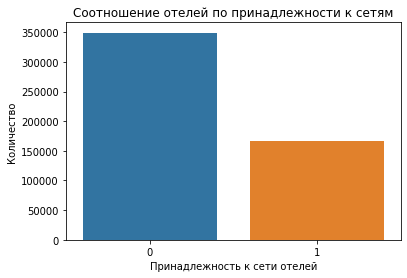

In [95]:
axes = sns.countplot(data=data, x='in_hotel_chain')
axes.set(xlabel = 'Принадлежность к сети отелей', ylabel='Количество')
plt.title('Соотношение отелей по принадлежности к сетям')
plt.show()

### 2.1.2 hotel_address

Посмотрим общее количество записей об адресах.

In [96]:
print('Общее количество адресов в датафрейме - {}'.format(data['hotel_address'].nunique()))

Общее количество адресов в датафрейме - 1493


У нас 1493 адреса, а отелей с уникальными наименованиями, как мы выяснили в предудущем блоке - 1494.

Поищем отели с различными названиями и одинаковыми адресами.

In [97]:
hotel_intersection = pd.DataFrame()
hotel_intersection = data.drop_duplicates(subset=['hotel_name'])
duplicate_adres_df = hotel_intersection.groupby(
    'hotel_address')['hotel_name'].count().sort_values(ascending=False)
duplicate_adres = duplicate_adres_df.head(1).index[0]
print('Два отеля находятся по адресу: \033[4m{}'.format(duplicate_adres))

Два отеля находятся по адресу: 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom


Посмотрим, что это за отели, проверим в интернете информацию по их адресам.

In [98]:
hotel_intersection[hotel_intersection['hotel_address']
                   == duplicate_adres]['hotel_name']

310    Club Quarters Hotel Trafalgar Square
875           The Grand at Trafalgar Square
Name: hotel_name, dtype: object

по данным сайтов отелей адреса:

- Club Quarters Hotel Trafalgar Square - "8 Northumberland Avenue, London, England WC2N 5BY"
- The Grand at Trafalgar Square - "8 Northumberland Ave, London WC2N 5BY"

Таким образом действительно есть два отеля, расположенных по одному адресу.

Общее количество адресов слишком большое для создания категориальных переменных, попробуем из структуры адреса выделить компоненты, на основании которых можно создать новые признаки.
> Расмотрим внимательнее структуру адреса 

In [99]:
list(data['hotel_address'][:10])

['Via Senigallia 6 20161 Milan Italy',
 'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
 'Mallorca 251 Eixample 08008 Barcelona Spain',
 'Piazza Della Repubblica 17 Central Station 20124 Milan Italy',
 'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands',
 'Coram Street Camden London WC1N 1HT United Kingdom',
 'Empire Way Wembley Brent London HA9 8DS United Kingdom',
 '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
 '35 Rue Caumartin 9th arr 75009 Paris France',
 '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom']

В структуре адреса можно выделить наименование улицы и номер дома, почтовый индекс, название города и название страны.
Среди них могут представлять интерес стран, город и почтовый индекс с которым можно связать район города.

Создадим новые признаки:
- *country* - страна
- *city* - город
- *zip_code* - почтовый индех

In [100]:
# извлекаем признак "страна"
def get_country(string):
    """ Функция извлекающая из названия отеля название страны

    Args:
        string (str): строкое значение признака 'hotel_address', 
        передаваемое в обработку

    Returns:
        str: возвращает название страны
    """
    
    if string.split(' ')[-1] == 'Kingdom':
        return 'United Kingdom'
    else:
        return string.split(' ')[-1]


data['country'] = data['hotel_address'].apply(lambda x: get_country(x))
print('пустых строк {}'.format(
      data[data['country'].isnull()]['country'].count()))
print('\n\033[4mСтраны')
data['country'].value_counts()

пустых строк 0

Страны


United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: country, dtype: int64

In [101]:
# извлекаем признак "город"
def get_city(string):
    """ Функция извлекающая из названия отеля название города

    Args:
        string (str): строкое значение признака 'hotel_address',
        передаваемое в обработку

    Returns:
        str: возвращает название города
    """
    
    if string.split(' ')[-1] != 'Kingdom': 
        return string.split(' ')[-2]
    else:
        return string.split(' ')[-5]


data['city'] = data['hotel_address'].apply(lambda x: get_city(x))
print('пустых строк {}'.format(data[data['city'].isnull()]['city'].count()))
print('\n\033[4mГорода')
data['city'].value_counts()

пустых строк 0

Города


London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: city, dtype: int64

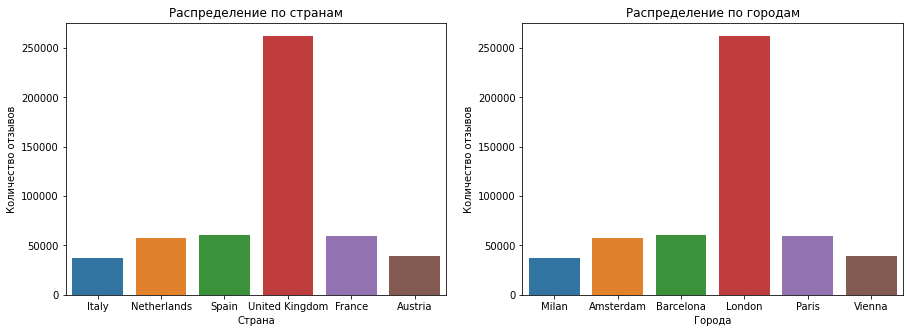

In [102]:
# отобразим соотношение на графиках
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, x='country', ax=axes[0])
axes[0].set(xlabel='Страна', ylabel='Количество отзывов')
axes[0].set_title('Распределение по странам')

sns.countplot(data=data, x='city', ax=axes[1])
axes[1].set(xlabel='Города', ylabel='Количество отзывов')
axes[1].set_title('Распределение по городам')

plt.show()

По распределению можно увидите, что оба признака имеют идентичное распределение, повторяют друг друга. А значит один из них лишний, и его нужно будет удалить на этапе отбора признаков. Создадим категориальный признак из признака *'country'*.
> выделим почтовый индекс

In [103]:
# извлекаем признак "почтового индекса"
def get_zip_code(string):
    """ Функция извлекающая из названия отеля почтовый индекс

    Args:
        string (str): строкое значение признака 'hotel_address', 
        передаваемое в обработку

    Returns:
        str: возвращает почтовый индекс
    """
    
    if string.split(' ')[-1] != 'Kingdom' and string.split(' ')[-1] != 'Netherlands': 
        return string.split(' ')[-3]
    else:
        return string.split(' ')[-4]


data['zip']=data['hotel_address'].apply(lambda x: get_zip_code(x))
print('пустых строк {}'.format(data[data['zip'].isnull()]['zip'].count()))
print('\n\033[4mПочтовые индексы')
data['zip'][:10]

пустых строк 0

Почтовые индексы


0    20161
1     1043
2    08008
3    20124
4     1012
5     WC1N
6      HA9
7       W6
8    75009
9      W1U
Name: zip, dtype: object

На уровень отеля влияет в том числе и его расположение относительно престижных и туристически привлекательных районов. Такое подразделение весьма условно и не имеет чётких границ и критериев, однако существует в качестве субъективного критерия. Учитывая условность подразделения выбираю 3 уровня признака приближенности к центру и туристическим объектам. Для создания признака необходимо создать таблицу сопоставления кодов индексов и уровня признака. Такую таблицу я создал по информации о почтовых индексах, доступной в интернете. 

Создадим признак *top_code* - уровень приближенности к центру и туристическим объектам

In [104]:
# загужаем дополнительный датасет
ZIP_DIR = '/kaggle/input/added-zip-list/'
df_zip = pd.read_csv(ZIP_DIR+'/new_zip_list.csv')

#объединяем датасеты
data = pd.merge(data,df_zip, on='zip', how='left')        
print('пустых строк {}'.format(data[data['top'].isnull()]['top'].count()))
print('\n\033[4mКод престижности')
data['top'][:5]

пустых строк 0

Код престижности


0    3
1    3
2    3
3    2
4    1
Name: top, dtype: int64

Визуализируем распределение по топ-признакам средних оценок отелей в различных городах.

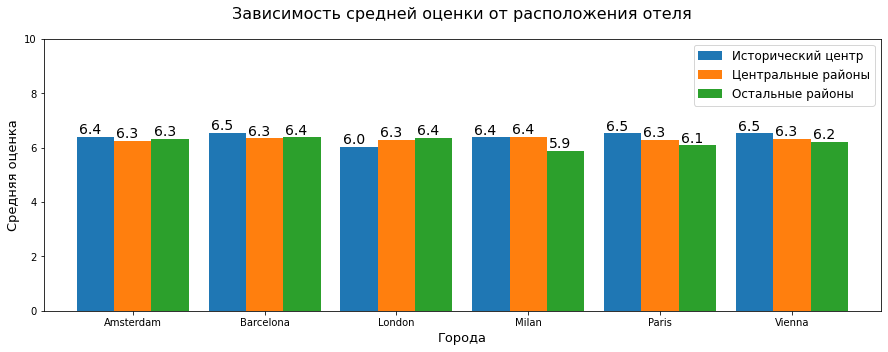

In [105]:
cross_table = data.groupby(
    ['city', 'top'])['reviewer_score'].mean().unstack()

fig, axes = plt.subplots(figsize=(15, 5))
plot = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)

axes.set_title('Зависимость средней оценки от расположения отеля', 
               pad=20, 
               size=16)
axes.set_xlabel('Города', 
                fontsize=13)
axes.set_ylabel('Средняя оценка', 
                fontsize=13)
axes.legend(['Исторический центр', 'Центральные районы', 'Остальные районы'], 
            loc='upper right', 
            fontsize=12)

for num in plot.patches:
    plot.annotate(
        '{:.1f}'.format(num.get_height()), 
        (num.get_x()+0.1, 
        num.get_height()),
        ha='center', 
        va='bottom', 
        fontsize=14)

plt.ylim(0, 10)
plt.show();

Ярко выраженных отличий в оценках, в зависимости от значения коэффициента, на первый взгляд,  не наблюдается. Тенденции в разных городах разнонаправлены.

Однако признак может иметь значение, рассмотрим его значимость на следующем этапе.

Визуализируем распределение количества оценок, в зависимости от района города. 

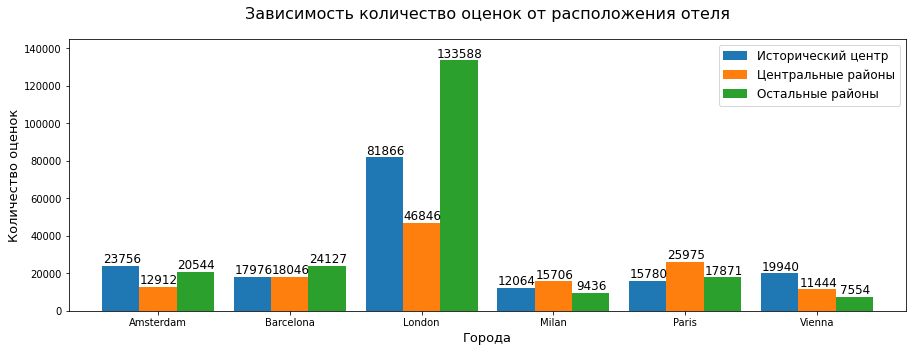

In [106]:
cross_table = data.groupby(
    ['city', 'top'])['reviewer_score'].count().unstack()

fig, axes = plt.subplots(figsize=(15, 5))
plot = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)

axes.set_title('Зависимость количество оценок от расположения отеля', 
               pad = 20, 
               size=16)
axes.set_xlabel('Города', 
                fontsize=13)
axes.set_ylabel('Количество оценок', 
                fontsize=13)
axes.legend(['Исторический центр', 'Центральные районы', 'Остальные районы'], 
            loc='upper right', 
            fontsize=12)

for num in plot.patches:
    plot.annotate(
                  num.get_height(), 
                  (num.get_x()+0.15, 
                  num.get_height()),
                  ha='center', 
                  va='bottom', 
                  fontsize=12)

plt.ylim(0, 145000)
plt.show();

В этом распределении так же не прослеживается единой тенденции, так же нет везде совпадают тенденции с предыдущим графиком. Признок не однозначен, но при обучении модели может быть полезен.

> создадим два синтетических признака:
- *top_reviewer* отношение оценки отеля к значению топ признака
- *top_city_count* произведение топ-прпризнака и доли данного значения признака для города в котором расположен отель

In [107]:
# создаем признак top_reviewer
data['top_reviewer']=data['reviewer_score']/data['top']

# создаем признак top_city_count
cross_table=data.groupby(
    ['city', 'top'])['reviewer_score'].count().unstack()

cross_table_sum=data.groupby(
    ['city'])['reviewer_score'].count()


# расчёт доли для каждого значения топ-признака по городам
def hew_feature_top_city(city, top):
    return cross_table[top][city]/cross_table_sum[top]*top
    

data['top_city_count']=data.apply(
    lambda x: hew_feature_top_city(x['city'],x['top']), axis=1)

Оценим статистику и распределение

In [108]:
data['top_reviewer'].describe()

count    515431.000000
mean          3.754437
std           3.166144
min           0.000000
25%           0.000000
50%           3.200000
75%           5.000000
max          10.000000
Name: top_reviewer, dtype: float64

In [109]:
data['top_city_count'].describe()

count    515431.000000
mean          3.347300
std           4.423588
min           0.087259
25%           0.298858
50%           1.361053
75%          10.771488
max          10.771488
Name: top_city_count, dtype: float64

Визуализируем распределение полученных признаков

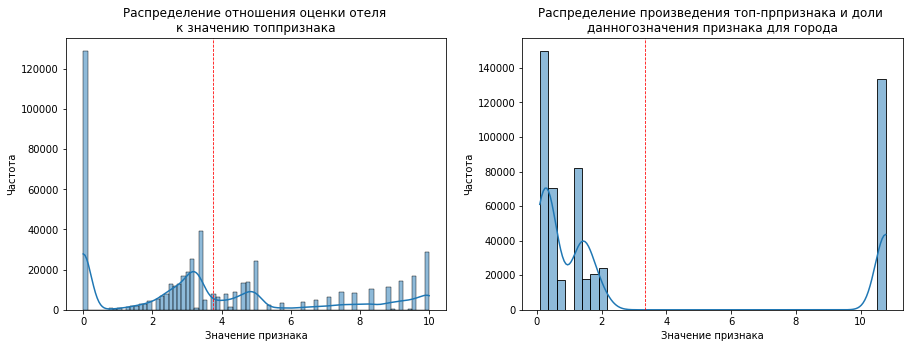

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['top_reviewer'], 
             kde=True, 
             ax=axes[0])
axes[0].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[0].set_title('Распределение отношения оценки отеля \nк значению топ\
признака')
axes[0].axvline(data['top_reviewer'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

sns.histplot(data['top_city_count'], 
             kde=True, 
             ax=axes[1])
axes[1].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[1].set_title('Распределение произведения топ-прпризнака и доли \nданного\
значения признака для города')
axes[1].axvline(data['top_city_count'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

plt.show()

Распределение весьма далеко от нормального, попробуем прологарифмировать признак, предварительно нормализовав его.

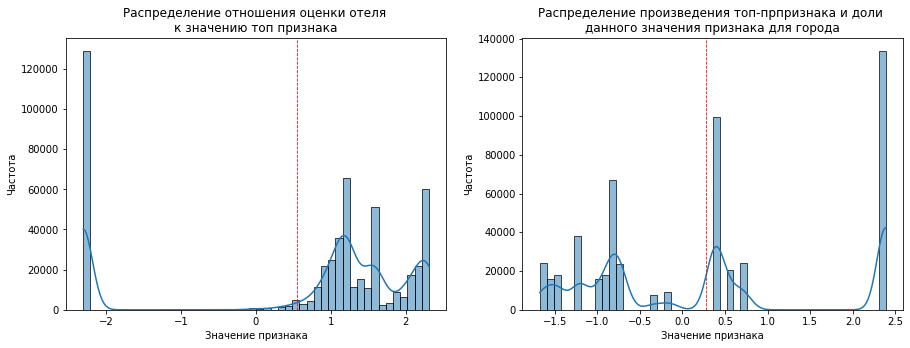

In [111]:
scaler = MinMaxScaler()
# предварительно нормализуем признаки
data['top_reviewer_norm']=scaler.fit_transform(
    pd.DataFrame(data['top_reviewer']))
data['top_city_count_norm']=scaler.fit_transform(
    pd.DataFrame(data['top_city_count']))

# логарифмируем
data['log_top_reviewer']=np.log(data['top_reviewer']+0.1)
data['log_top_city_count']=np.log(data['top_city_count']+0.1)

# визуализируем результат
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['log_top_reviewer'], 
             kde=True, 
             ax=axes[0])
axes[0].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[0].set_title(
    'Распределение отношения оценки отеля \nк значению топ признака')
axes[0].axvline(data['log_top_reviewer'].mean(),
                color='red', 
                linestyle='--', 
                linewidth=0.8)

sns.histplot(data['log_top_city_count'], 
             kde=True, 
             ax=axes[1])
axes[1].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[1].set_title(
    'Распределение произведения топ-прпризнака и доли \nданного значения \
признака для города')
axes[1].axvline(data['log_top_city_count'].mean(),
                color='red', 
                linestyle='--', 
                linewidth=0.8)

plt.show()

В результате преобразований распределение признаков несколько приблизилось к нормальному, однако остаётся смещённым. В то же время значение средней меры сместилось ближе к середине, что даёт надежду на эффективность признаков.

Полученные виртуальные признаки можно будет оценить на этапе отбора признаков.

### 2.1.3 average_score

Оценим статистику и распределение

In [112]:
data['average_score'].describe()

count    515431.000000
mean          8.397630
std           0.548033
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

Визуализируем распределение признака

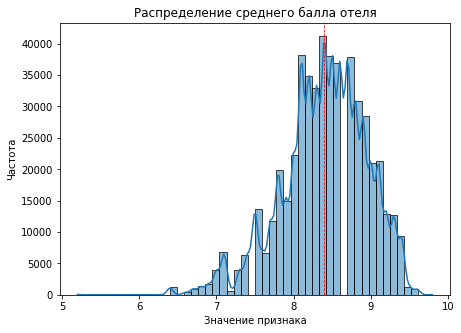

In [113]:
# строим визуализацию
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

sns.histplot(data['average_score'], 
             bins=50, 
             kde=True, 
             ax=axes)
axes.set(xlabel='Значение признака', 
         ylabel='Частота')
axes.set_title('Распределение среднего балла отеля')
axes.axvline(data['average_score'].mean(), 
             color='red', 
             linestyle='--', 
             linewidth=0.8)

plt.show()

Распределение признака близко к нормальному, с умеренно длинным левым хвостом, оставим как есть.

### 2.1.4 total_number_of_reviews

Оценим статистику и распределение

In [114]:
data['total_number_of_reviews'].describe()

count    515431.000000
mean       2744.259084
std        2317.823718
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3633.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

Визуализируем распределение признака

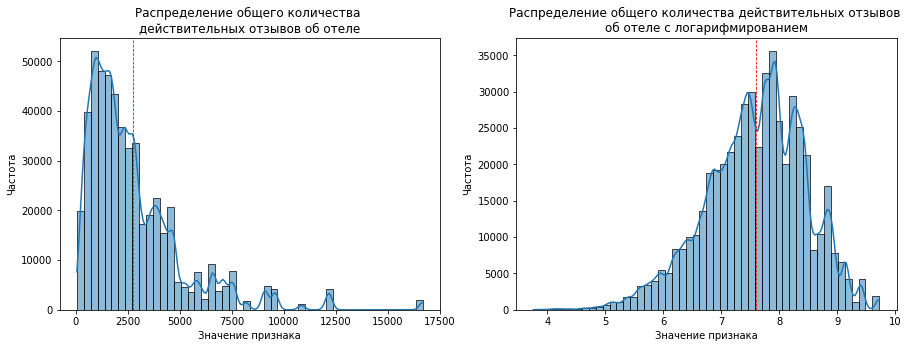

In [115]:
# строим визуализацию
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['total_number_of_reviews'], 
             bins=50, 
             kde=True, 
             ax=axes[0])
axes[0].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[0].set_title('Распределение общего количества \nдействительных отзывов об отеле')
axes[0].axvline(data['total_number_of_reviews'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

# логарифмируем признак и строим визуализацию 
plot_score=pd.DataFrame()
plot_score['total_number_of_reviews']=np.log(data['total_number_of_reviews'])

sns.histplot(plot_score['total_number_of_reviews'], 
             bins=50, 
             kde=True, 
             ax=axes[1])
axes[1].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[1].set_title('Распределение общего количества действительных отзывов \n\
об отеле с логарифмированием')
axes[1].axvline(plot_score['total_number_of_reviews'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)
plt.show();

Распрееление признака смещено влево, с длинным правым хвостом.

В результате логарифмирования распределение признака несколько приблизилось к нормальному. В то же время значение средней меры сместилось ближе к середине. Добавим логарифмированный признак и оценим его значимость на следущем этапе.

In [116]:
data['log_total_number_of_reviews'] = np.log(data['total_number_of_reviews'])

Создадим синтетический признак:

- *multiplication_number_of_reviews* - логарифмированный 'total_number_of_reviews', умноженный на 'average_score'

In [117]:
data['multiplication_number_of_reviews'] = data['log_total_number_of_reviews'] * \
    data['average_score']

Оценим статистики и визуализируем признак

In [118]:
data['multiplication_number_of_reviews'].describe()

count    515431.000000
mean         63.645542
std           7.540031
min          31.938595
25%          58.728261
50%          64.144203
75%          68.732315
max          81.829961
Name: multiplication_number_of_reviews, dtype: float64

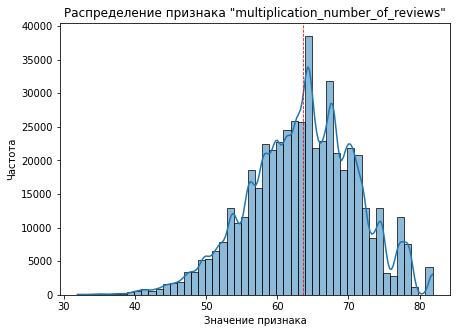

In [119]:
# визуализируем распределение признака
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

sns.histplot(data['multiplication_number_of_reviews'],
             bins=50, 
             kde=True, 
             ax=axes)
axes.set(xlabel='Значение признака', 
         ylabel='Частота')
axes.set_title('Распределение признака "multiplication_number_of_reviews"')
axes.axvline(data['multiplication_number_of_reviews'].mean(),
             color='red', 
             linestyle='--', 
             linewidth=0.8)

plt.show();

Распределение признака напоминает логнормальное, оставим как есть.

### 2.1.5 additional_number_of_scoring

Оценим статистики и визуализируем признак

In [120]:
data['additional_number_of_scoring'].describe()

count    515431.000000
mean        498.275079
std         500.618961
min           1.000000
25%         169.000000
50%         342.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

Есть признаки смещения распределения влево.

Визуализируем распределение и оценим влияние логарифмирования.

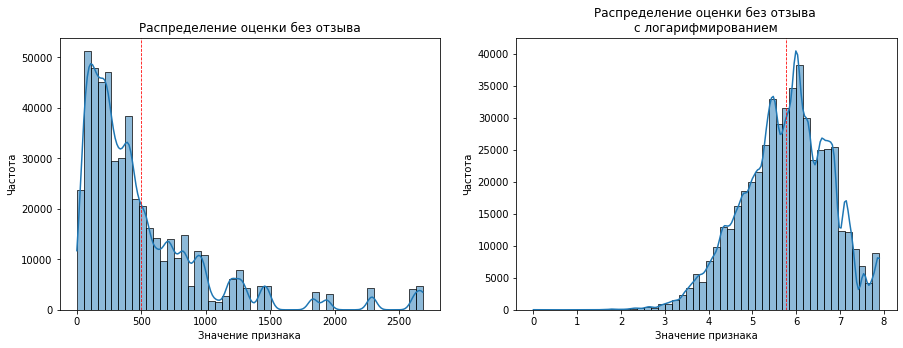

In [121]:
# визуализируем распределение признака
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['additional_number_of_scoring'], 
             bins=50, 
             kde=True, 
             ax=axes[0])
axes[0].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[0].set_title('Распределение оценки без отзыва')
axes[0].axvline(data['additional_number_of_scoring'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

# логарифмируем признак и строим визуализацию 
plot_score=pd.DataFrame()
plot_score['additional_number_of_scoring'] = np.log(
    data['additional_number_of_scoring'])

sns.histplot(plot_score['additional_number_of_scoring'], 
             bins=50, 
             kde=True, 
             ax=axes[1])
axes[1].set(xlabel='Значение признака', 
            ylabel='Частота')
axes[1].set_title('Распределение оценки без отзыва \nс логарифмированием')
axes[1].axvline(plot_score['additional_number_of_scoring'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

plt.show()

В результате логарифмирования распределение признака приблизилось к нормальному, будем использовать логарифмирование.

In [122]:
data['log_additional_number_of_scoring'] = np.log(
    data['additional_number_of_scoring'])

### 2.1.6 координаты - признаки *lat* и *lng* 

Координаты - широта и долгота взаимосвязаны, поэтому расмотрим их в совокупности.

Эти два признака, единственные, из всей совокупности имеют пропуски, пропущенные позиции совпадают.
Посмотрим для каких отелей отсутствуют координаты:


In [123]:
print('Отелей с пустыми координатами {}\n'.format(
    data[data['lat'].isna()]['hotel_name'].nunique()))
list(set(data[data['lat'].isna()]['hotel_name']))

Отелей с пустыми координатами 17



['Hotel City Central',
 'Mercure Paris Gare Montparnasse',
 'Hotel Atlanta',
 'Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Holiday Inn Paris Montmartre',
 'NH Collection Barcelona Podium',
 'Hotel Advance',
 'Roomz Vienna',
 'Hotel Pension Baron am Schottentor',
 'Cordial Theaterhotel Wien',
 'Hotel Park Villa',
 'Renaissance Barcelona Hotel',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Hotel Daniel Vienna',
 'Fleming s Selection Hotel Wien City',
 'City Hotel Deutschmeister']

Попробуем поискать в датафрейме записи об этих отелях с координатами:

In [124]:
%%time
lat_null = data[data['lat'].isna()]['hotel_name']
lat_not_null = data[data['lat'].isna() == False]['hotel_name']
num_coordinates = 0

for nitem in lat_not_null:
    for item in lat_null:
        if item == nitem:
            num_coordinates+=1
    
print('Обнаружено {} записей'.format(num_coordinates))

Обнаружено 0 записей
CPU times: user 6min 37s, sys: 81.7 ms, total: 6min 37s
Wall time: 6min 37s


Поскольку таковых не обнаружено, попробуем для поиска координат использовать библиотеку "geopy". 

In [125]:
# начальные параметры 
locator = Nominatim(user_agent="kaggle_address")


# зададим функции
def get_coordinates_address(addresses):
    """ Функция получает координаты по адресу

    Args:
        string (str): список адресов отелей, передаваемых в обработку

    Returns:
        str: возвращает словарь с ключами - переданными адресами
        и значением - списком [широт, долгота]
    """
    ret_dict = dict()
    for addres in addresses:
        if addres.split(' ')[-1] != 'Kingdom':
            short_addres = ' '.join(addres.split(' ')[:-2])
        else:
            short_addres = ' '.join(addres.split(
                ' ')[:-5])+' '+' '.join(addres.split(' ')[-4:-2])
        location = locator.geocode(short_addres)
        if location:
            ret_dict[addres] = [location.latitude, location.longitude]
        else:
            ret_dict[addres] = 'not'
    return ret_dict


def get_coordinates_name(name):
    """ Функция получает координаты по наименованию отеля

    Args:
        string (str): список наименований отелей, передаваемые в обработку

    Returns:
        str: возвращает словарь с ключами - переданными названиями
        и значением - списком [широт, долгота]
    """
    ret_dict = dict()
    for item in name:
        location = locator.geocode(item)
        if location:
            ret_dict[item] = [location.latitude, location.longitude]
        else:
            ret_dict[item] = 'not'
    return ret_dict

In [126]:
# сформируем список наименовай отелей без координта и получим по ним координаты
name = list(set(data[data['lat'].isna()]['hotel_name']))
lat_lng_coordinates = get_coordinates_name(name)
lat_lng_coordinates 

{'Hotel City Central': [48.2135658, 16.3799212],
 'Mercure Paris Gare Montparnasse': 'not',
 'Hotel Atlanta': [50.8520697, 4.354408380443903],
 'Austria Trend Hotel Schloss Wilhelminenberg Wien': [48.2196753, 16.2854959],
 'Derag Livinghotel Kaiser Franz Joseph Vienna': 'not',
 'Holiday Inn Paris Montmartre': [48.8715708, 2.3436597],
 'NH Collection Barcelona Podium': [41.39188235, 2.1779639552623635],
 'Hotel Advance': [27.9124545, 84.8838653],
 'Roomz Vienna': [48.18672145, 16.420653090404993],
 'Hotel Pension Baron am Schottentor': 'not',
 'Cordial Theaterhotel Wien': [48.20966395, 16.35142625097432],
 'Hotel Park Villa': [49.13646555, 9.230946491810585],
 'Renaissance Barcelona Hotel': [41.3927154, 2.1674921],
 'Maison Albar Hotel Paris Op ra Diamond': 'not',
 'Hotel Daniel Vienna': [48.1888627, 16.3838516356697],
 'Fleming s Selection Hotel Wien City': 'not',
 'City Hotel Deutschmeister': 'not'}

Заполнились не все координты, поробуем поискать по адресам

In [127]:
adresses = list(set(data[data['lat'].isna()]['hotel_address']))
lat_lng_coordinates_address = get_coordinates_address(adresses)
lat_lng_coordinates_address

{'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 'not',
 '23 Rue Damr mont 18th arr 75018 Paris France': 'not',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 'not',
 'Bail n 4 6 Eixample 08010 Barcelona Spain': 'not',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 'not',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 'not',
 '20 Rue De La Ga t 14th arr 75014 Paris France': 'not',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 'not',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 'not',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 'not',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 'not',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 'not',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 'not',
 'Sep lveda 180 Eixample 08011 Barcelona Spain': 'not',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 'not',
 '4 rue de la P pini re 8th arr 75008 Paris France': 'not',
 'Pau Clar

Результат ещё более печален, не нашлось ничего.

Получим список отелей, у которых координаты не заполнились по наименованиям:

In [128]:
for item in lat_lng_coordinates.items():
    if item[1] == 'not':
        print(item[0])

Mercure Paris Gare Montparnasse
Derag Livinghotel Kaiser Franz Joseph Vienna
Hotel Pension Baron am Schottentor
Maison Albar Hotel Paris Op ra Diamond
Fleming s Selection Hotel Wien City
City Hotel Deutschmeister


По сайтам отелей в сети интернет найдены верные адреса, по ним повторно запросим координаты.

In [129]:
new_address_dict = {
    'Fleming s Selection Hotel Wien City':'Josefstädter Straße 10-12 1080 Vienna Austria',
    'Mercure Paris Gare Montparnasse':'75014 PARIS, France',
    'Hotel Pension Baron am Schottentor':'Währinger Straße 12 1090 Vienna Austria',
    'Maison Albar Hotel Paris Op ra Diamond':'4 rue de la Pépinière 75008 Paris France',
    'City Hotel Deutschmeister':'Grünentorgasse 30 09 Alsergrund 1090 Vienna',
    'Derag Livinghotel Kaiser Franz Joseph Vienna':'Sieveringer Straße 4 1190 Vienna Austria'
}
    
new_lat_lng_coordinates = get_coordinates_address(list(new_address_dict.values()))
new_lat_lng_coordinates

{'Josefstädter Straße 10-12 1080 Vienna Austria': [48.2104394, 16.3447872],
 '75014 PARIS, France': [48.8295667, 2.3239624642685364],
 'Währinger Straße 12 1090 Vienna Austria': [48.216813, 16.3599356],
 '4 rue de la Pépinière 75008 Paris France': [48.875248, 2.3233746],
 'Grünentorgasse 30 09 Alsergrund 1090 Vienna': [48.2211573, 16.3620293],
 'Sieveringer Straße 4 1190 Vienna Austria': [48.2460659, 16.3412619]}

координаты получены, дополним датафрейм полученными данными.

Для ускорения обработки выделим столбцы с наименованием отеля и его координатами в отдельный датафрейм с уникальными строками по названию отеля и после обработки объединим с основным датафреймом.

In [130]:
columns = set(data.columns)
drop_columns = list(columns-{'hotel_name','city','lat','lng'})
name_lat_lng = data.copy()
data = data.drop(['lat','lng'], axis = 1)
name_lat_lng.drop_duplicates(subset=['hotel_name'], inplace=True)
name_lat_lng = name_lat_lng.drop(drop_columns, axis = 1)
name_lat_lng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 0 to 117586
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hotel_name  1494 non-null   object 
 1   lat         1477 non-null   float64
 2   lng         1477 non-null   float64
 3   city        1494 non-null   object 
dtypes: float64(2), object(2)
memory usage: 58.4+ KB


In [131]:
for item in lat_lng_coordinates.items():
    if item[1] == 'not':
        lat_lng_coordinates[item[0]
                           ] = new_lat_lng_coordinates[new_address_dict[item[0]]]

        
for index, row in name_lat_lng.iterrows():
    if np.isnan(row['lat']):
        name_lat_lng.loc[name_lat_lng['hotel_name'] == row['hotel_name'],
                         'lat'] = lat_lng_coordinates[row['hotel_name']][0]
        name_lat_lng.loc[name_lat_lng['hotel_name'] == row['hotel_name'],
                         'lng'] = lat_lng_coordinates[row['hotel_name']][1]
  
        
print('Осталось пустых значений {}'.format(
      name_lat_lng[name_lat_lng['lat'].isna()]['lat'].count()))

Осталось пустых значений 0


Сами по себе координаты малоинформативны, попробуем на их основании создать дополнительный признак - расстояние от центра города. 

Для этого подготовлен словарь с координатами центов городов. Создадим дополнительный признак:
 - *centr_distance* - расстояние от центра

In [132]:
# словарь с координатами
coord_dict = {'Paris':[48.8534100, 2.3488000], 
              'London':[51.5085300, -0.1257400],
              'Barcelona':[41.3887900, 2.1589900], 
              'Amsterdam':[52.3740300, 4.8896900],
              'Vienna':[48.2084900, 16.3720800], 
              'Milan':[45.4642700, 9.1895100]}

#расчёт расстояния
def get_dist_to_centr(city, lat, lng):
    return geopy.distance.geodesic([coord_dict[city][0], coord_dict[city][1]],
                                   [lat, lng]).km

name_lat_lng['distance_to_centr'] = name_lat_lng.apply(
    lambda x: get_dist_to_centr(x.city, x.lat, x.lng), axis = 1)
name_lat_lng['distance_to_centr'][:10]


0     7.788060
1     3.978037
2     0.532699
3     1.815149
4     0.394315
5     1.735055
6    12.382209
7     6.806520
8     2.581984
9     2.510187
Name: distance_to_centr, dtype: float64

Добавим сведения о населении городов, в которых расположены отели, индекс Джини (данные ООН), индекс удовлетворённости жизни для страны в которой расположен отель.

In [133]:
# подготовим словарь с коэффициентами
coeff_dict = {
    'Paris': [2.148327, 200, 32, 7],
    'London': [8.961989, 236.67, 36],
    'Barcelona': [1.636193, 233.33, 34, 7],
    'Milan': [1.378689, 230, 36],
    'Vienna': [1.897491, 260, 29, 1],
    'Amsterdam': [0.872757, 250, 30, 9],
}

# добавим данные в датасет
for index, row in name_lat_lng.iterrows():
    name_lat_lng.loc[name_lat_lng['city'] == row['city'],
                     'population'] = coeff_dict[row['city']][0]
    name_lat_lng.loc[name_lat_lng['city'] == row['city'],
                     'contentment'] = coeff_dict[row['city']][1]
    name_lat_lng.loc[name_lat_lng['city'] == row['city'],
                     'dgini'] = coeff_dict[row['city']][2]

Попробуем нормализовать новые признаки.

In [134]:
scaler = MinMaxScaler()
name_lat_lng['population_norm'] = scaler.fit_transform(
    name_lat_lng[['population']])
name_lat_lng['contentment_norm'] = scaler.fit_transform(
    name_lat_lng[['contentment']])
name_lat_lng['dgini_norm'] = scaler.fit_transform(name_lat_lng[['dgini']])

Объединяем датафреймы

In [135]:
name_lat_lng.drop(['city'], axis = 1)
data = data.merge(name_lat_lng, on='hotel_name', how='left')
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lat,lng,city_y,distance_to_centr,population,contentment,dgini,population_norm,contentment_norm,dgini_norm
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,45.533137,9.171102,Milan,7.788060,1.378689,230.00,36.0,0.062544,0.500000,1.000000
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,52.385649,4.834443,Amsterdam,3.978037,0.872757,250.00,30.0,0.000000,0.833333,0.142857
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,41.393192,2.161520,Barcelona,0.532699,1.636193,233.33,34.0,0.094377,0.555500,0.714286


Оценим значимость полученных признаков на следующем этапе.

### 2.1.7 review_date

Преобразуем колонку в формат даты, создадим новые признаки и проанализируем их:

- *year* - год
- *month* - месяц
- *week_day* - день недели

In [136]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['week_day'] = data['review_date'].dt.weekday + 1

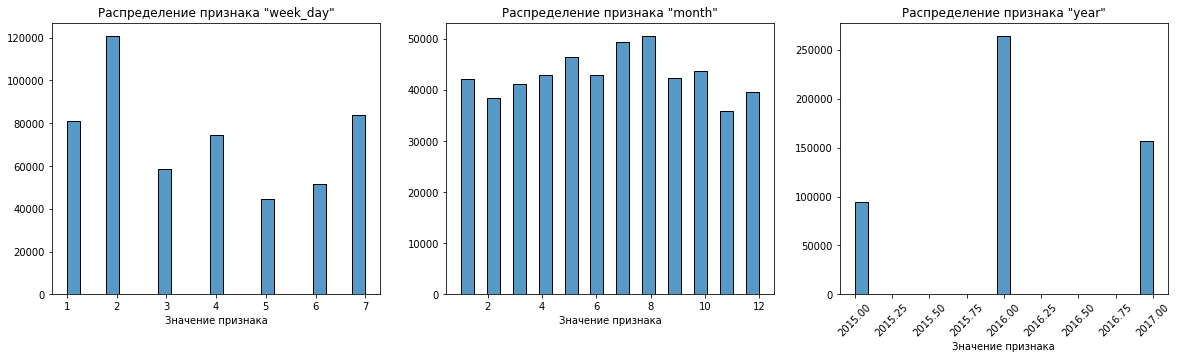

In [137]:
# задаем список столбцов
col_data=['week_day','month','year']

# визуализируем распределение
fig, ax = plt.subplots(1, 3, figsize=(20, 5)) 

# отрисовываем в цикле                                                                                          
for num, col in enumerate(col_data):          
    sns.histplot(data[col], bins=23, ax = ax[num]) 
    ax[num].set(xlabel='Значение признака')
    ax[num].set(ylabel='')
    ax[num].set_title('Распределение признака "{}"'.format(col))

plt.xticks(rotation = 45)
plt.show()

Можно увидеь, что наибольшее количество отзывов по 2016 году. 

Преимущественно в летний период и период новогодних праздников. 

А из дней недели преобладает, с заметным отрывом, вторник.

Посмотрим как распределились оценки по этим периодам.

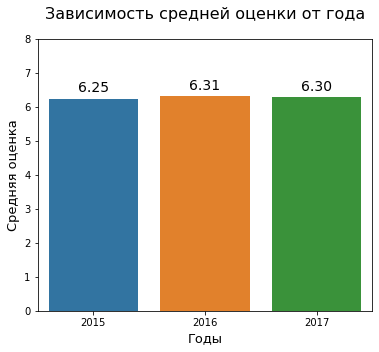

In [138]:
# построим график зависимости средней оценки от года
build_barplot(data, 'year', 'reviewer_score', 'mean',
              ['Зависимость средней оценки от года', 'Годы', 'Средняя оценка'], 0, 6)

Средняя оценка по годам практически неизменна, по этой причине признак по сути бесполезен попробуем создать на его основе новый признак, после чего столбец удалим:

- *year_reviewe* - произведение средней оценки в году на количество отзывов в этом году, разделенное на 100000

In [139]:
year_cross_count = data.groupby('year')['reviewer_score'].count()/100000
year_cross_table = data.groupby('year')['reviewer_score'].mean()
data['year_reviewe'] = data.apply(
    lambda x: year_cross_table[x.year] * year_cross_count[x.year], axis=1)
data = data.drop('year', axis=1)

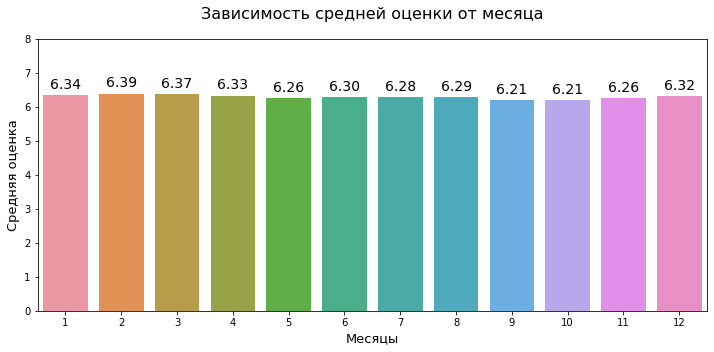

In [140]:
# построим график зависимости средней оценки от месяца
build_barplot(data, 'month', 'reviewer_score', 'mean',
              ['Зависимость средней оценки от месяца', 'Месяцы', 'Средняя оценка'],0, 12)

По месяцам колебания не велики, однако поскольку есть заметное различие по количеству отзывов по месяцам можно создать синтетический признак:
- *month_reviewe* - произведение средней оценки в месяце на количество отзывов в этом месяце, разделенное на 10000.

In [141]:
month_cross_count = data.groupby('month')['reviewer_score'].count()/10000
month_cross_table = data.groupby('month')['reviewer_score'].mean()
data['month_reviewe'] = data.apply(
    lambda x: month_cross_table[x.month] * month_cross_count[x.month], axis=1)

Значимость признаков оценим на следующем этапе.

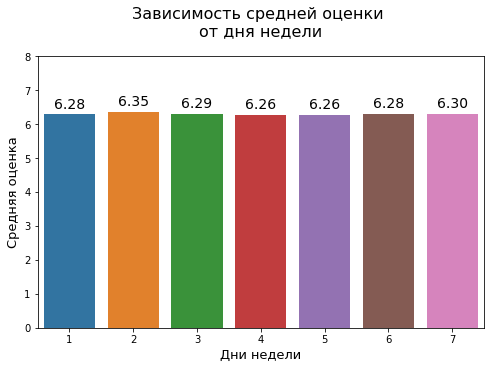

In [142]:
# построим график зависимости средней оценки от дня недели
build_barplot(data, 'week_day', 'reviewer_score', 'mean', 
              ['Зависимость средней оценки \nот дня недели', 'Дни недели', 'Средняя оценка'],0, 8)

Колебания средней оценки по дням недели так же незначительны, поступим так же как и с месяцем, создадим новый признак:
- *week_reviewe* - средняя оценка по дню недели, умноженная на количество отзывов в день недели 

In [143]:
week_day_cross_count = data.groupby('week_day')['reviewer_score'].count()/10000
week_day_cross_table = data.groupby('week_day')['reviewer_score'].mean()
data['week_reviewe'] = data.apply(
    lambda x: week_day_cross_table[x.week_day] * week_day_cross_count[x.week_day], axis=1)

Значимость признаков оценим на следующем этапе.

### 2.2.1 days_since_review

Признак не выглядит многообещающим, не очень понятен его смысл, приведем признак к числовому виду и посмотрим на его распределение.

In [144]:
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split()[0])).astype('int16')
data['days_since_review'][:5]

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int16

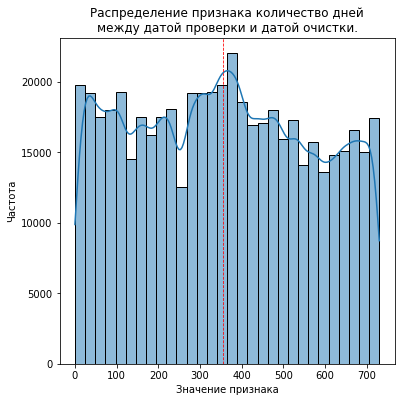

In [145]:
# визуализируем распределение
fig, axes = plt.subplots(figsize=(6, 6))

sns.histplot(data['days_since_review'], 
             bins=30, 
             kde=True, 
             ax=axes)
axes.set(xlabel='Значение признака', 
         ylabel='Частота')
axes.set_title('Распределение признака количество дней\nмежду датой проверки и датой очистки.')
axes.axvline(data['days_since_review'].mean(), 
             color='red', 
             linestyle='--', 
             linewidth=0.8)

plt.show();

Распределение достаточно равномерное, с не смещённой средней мерой.

CPU times: user 53.4 s, sys: 44.3 s, total: 1min 37s
Wall time: 24.9 s


Text(0.5, 1.0, 'Зависимость среднего значения reviewer_score от days_since_review')

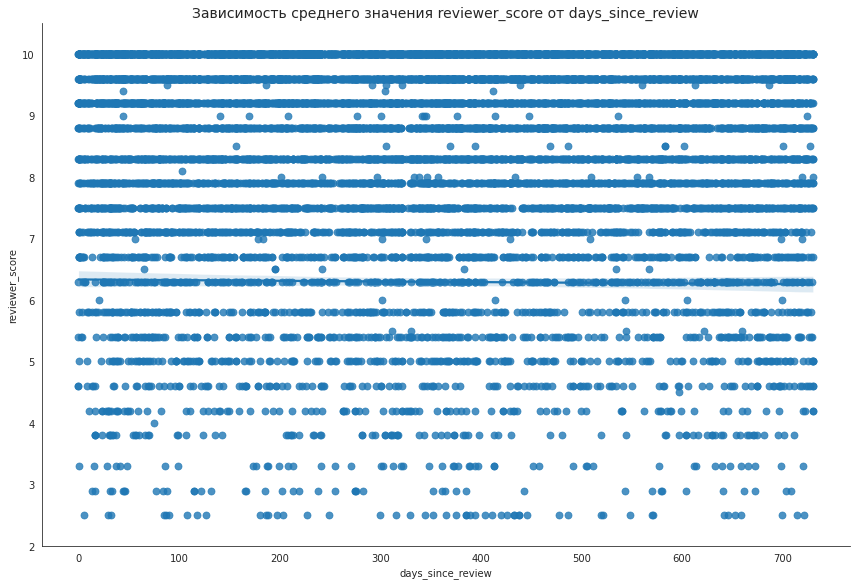

In [146]:
%%time
# визуализируем взаимоствяз среднего значения отзыва с количеством дней от отзыва
sns.set_style("white")
lmp = sns.lmplot(x="days_since_review", 
                 y="reviewer_score", 
                 data=data.sample(frac=0.03),
                 height=8, 
                 aspect=1.5, 
                 robust=True, 
                 palette="pastel", 
                 scatter_kws=dict(s=50, linewidths=.7))
lmp.set(ylim=(2, 10.5))
plt.title('Зависимость среднего значения reviewer_score от days_since_review', 
          fontsize=14);

По графику можно сделать вывод, что среднее значение оценки от количества дней не зависит.

Существенных взаимосвязей выявить не удалось, однако до момента оценки значимости не будем торопиться,

### 2.2.2 negative_review, positive_review


Признаки непосредственно связанные с отзывами, содержат информацию о положительных и отрицательных отзывах.

Проанализируем их с помощью библиотеки nltk, определим степень отрицательной и положительной окраски отзыва.

Сначала посмотрим на структуру данных.

In [147]:
# посмотрим частоты слов в позитивном 
data['positive_review'].value_counts().head(25)

No Positive            35924
 Location               9213
 Everything             2284
 location               1674
 Nothing                1242
 The location           1124
 Great location         1045
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          514
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           275
 Nothing                 224
 Comfy bed               222
 nothing                 217
 The location            215
 good location           206
 The staff               197
 Good breakfast          189
Name: positive_review, dtype: int64

In [148]:
# и негативном отзывах
data['negative_review'].value_counts().head(25)

No Negative            127816
 Nothing                14291
 Nothing                 4234
 nothing                 2223
 N A                     1037
 None                     984
                          849
 N a                      509
 Breakfast                407
 Small room               373
 Location                 367
 Everything               325
 All good                 318
 Nothing really           315
 none                     302
 nothing                  283
 No complaints            274
 Price                    260
 Nothing really           254
 Nil                      247
 n a                      227
 Nothing at all           221
 Nothing to dislike       209
 Nothing at all           194
 Small rooms              188
Name: negative_review, dtype: int64

Есть не однозначные словоформы, которые стоит скорректировать в однозначно позитивные и негативные, соответстсвенно.

Скорректируем явно негативные и явно позитивные отзывы

In [149]:
# создаем временные колонки
data['negative_review_temp'] = data['negative_review']
data['positive_review_temp'] = data['positive_review']

# cкорректируем явные словоформы 
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('N A', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('N a', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('n a', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review_temp'] = data['negative_review_temp'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review_temp'] = data['positive_review_temp'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [150]:
%%time
# переведём текст в нижний регистр и преобразуем строку в словарь
data['negative_review_list'] = data['negative_review_temp'].apply(
            lambda x: x.lower().split())
data['positive_review_list'] = data['positive_review_temp'].apply(
            lambda x: x.lower().split())

# удалим не текстовые символы
data['negative_review_list'] = data['negative_review_list'].apply(
            lambda x: [word for word in x if word.isalpha()])
data['positive_review_list'] = data['positive_review_list'].apply(
            lambda x: [word for word in x if word.isalpha()])

# преобразуем список в строку
data['negative_review_temp'] = data['negative_review_list'].apply(
            lambda x: ' '.join(x))
data['positive_review_temp'] = data['positive_review_list'].apply(
            lambda x: ' '.join(x))

data['negative_review_word_counts'] = data['negative_review_list'].apply(
            lambda x: len(x))
data['positive_review_word_counts'] = data['positive_review_list'].apply(
            lambda x: len(x))

data = data.drop(['negative_review_list','positive_review_list'], axis = 1)

CPU times: user 13.2 s, sys: 1.18 s, total: 14.4 s
Wall time: 14.4 s


Положительный и отрицательные отзывы - это ответы на два вопроса сайта о том что понравилось / не понравилось в отеле. 

В английском языке, ответ на вопрос “Что вам не понравилось?”: “Ничего” (nothing) - будет означать, что ничего не не понравилось, то есть - все понравилось.

В ответ на вопрос: “Что вам понравилось?: “Ничего” будет означать, что ничего не понравилось.

Оценим влияние этой осбенности на характер оценки.

In [151]:
# создаем два экземпляра анализатора, для позитивной и негаивной оценки 
positive_analyzer = SentimentIntensityAnalyzer()
negative_analyzer = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
world = 'nothing'
print('Словарь оценок слова "{}" до преобразований:'.format(world))
print(negative_analyzer.polarity_scores(world), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative_analyzer.lexicon.update(negative_words)
positive_analyzer.lexicon.update(positive_words)

# посмотрим результат
print('После преобразований negative":\n')
print(negative_analyzer.polarity_scores(world))
print('После преобразований "positive":\n')
print(positive_analyzer.polarity_scores(world))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

После преобразований negative":

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
После преобразований "positive":

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}


In [152]:
%%time
data['negative_review_grade'] = data['negative_review_temp'].apply(
    lambda x: negative_analyzer.polarity_scores(x))
data['positive_review_grade'] = data['positive_review_temp'].apply(
    lambda x: positive_analyzer.polarity_scores(x))

# формируем новые признаки:
data['negative_review_neg'] = data['negative_review_grade'].apply(
    lambda x: x['neg'])
data['negative_review_neu'] = data['negative_review_grade'].apply(
    lambda x: x['neu'])
data['negative_review_pos'] = data['negative_review_grade'].apply(
    lambda x: x['pos'])
data['negative_review_compound'] = data['negative_review_grade'].apply(
    lambda x: x['compound'])

data['positive_review_neg'] = data['positive_review_grade'].apply(
    lambda x: x['neg'])
data['positive_review_neu'] = data['positive_review_grade'].apply(
    lambda x: x['neu'])
data['positive_review_pos'] = data['positive_review_grade'].apply(
    lambda x: x['pos'])
data['positive_review_compound'] = data['positive_review_grade'].apply(
    lambda x: x['compound'])

# удалим временные столбцы
data = data.drop(['negative_review_grade','positive_review_grade',
                  'negative_review_temp','positive_review_temp'], 
                  axis=1)

CPU times: user 5min 29s, sys: 401 ms, total: 5min 29s
Wall time: 5min 29s


Визуализируем полученный результат

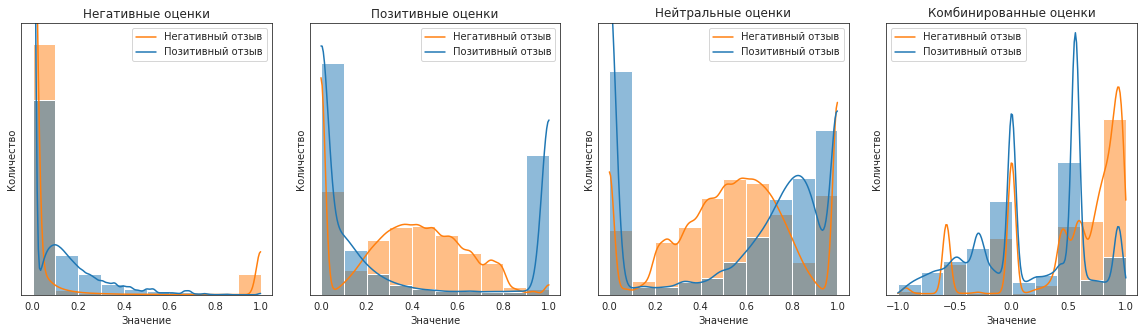

In [153]:
# Задаем словарь с параметрами
data_dict = {
    0: ['negative_review_neg', 'positive_review_neg', 500000, 'Негативные оценки'],
    1: ['negative_review_pos', 'positive_review_pos', 300000, 'Позитивные оценки'],
    2: ['negative_review_neu', 'positive_review_neu', 190000, 'Нейтральные оценки'],
    3: ['negative_review_compound', 'positive_review_compound', 330000, 'Комбинированные оценки']
}

# строим графики
afig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.subplots_adjust(wspace=.15)

for i in data_dict:
    sns.histplot(data=data[[data_dict[i][0], data_dict[i][1]]], 
                 bins=10, 
                 ax=axes[i], 
                 kde=True)
    axes[i].set_title(data_dict[i][3], 
                      fontsize=12)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Количество')
    axes[i].legend(labels=['Негативный отзыв','Позитивный отзыв'])
    axes[i].set_yticks([])
    axes[i].axes.set_ylim(0, data_dict[i][2])

plt.show()

Распределение полученных признаков разнообразно и разнонаправлдено, поскольку сведения достаточно специфичны, оставим как есть.

Проведем анализ при помощи библиотеки TextBlob, используемой для анализа целого предложения, выдавая такие параметры как: полярность и субъективность.

Для оценки настроения рецензента будем использовать оба параметра.

Поскольку бибилиотека работает со строкой и оценивает полярность и субъективность текста в целом, предварительные преообразования текста не нужны.



In [154]:
%%time

# получим полярность и субъективность
def get_polarity(text):
    """ Функция получения параметра полярности отзыва 
    
    Args:
        string (str): строка, передаваемая в обработку

    Returns:
        str: возвращает значение параметра полярности
    """
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity

def get_subjectivity(text):
    """ Функция получения параметра субъективности отзыва 
    
    Args:
        string (str): строка, передаваемая в обработку

    Returns:
        str: возвращает значение параметра субъективности
    """
    blob = TextBlob(text)
    return blob.sentiment_assessments.subjectivity

data['positive_polarity'] = data['positive_review'].apply(get_polarity)
data['negative_polarity'] = data['negative_review'].apply(get_polarity)
data['positive_subjectivity'] = data['positive_review'].apply(get_subjectivity)
data['negative_subjectivity'] = data['negative_review'].apply(get_subjectivity)

CPU times: user 17min 25s, sys: 104 ms, total: 17min 25s
Wall time: 17min 26s


Визуализируем полученные результаты

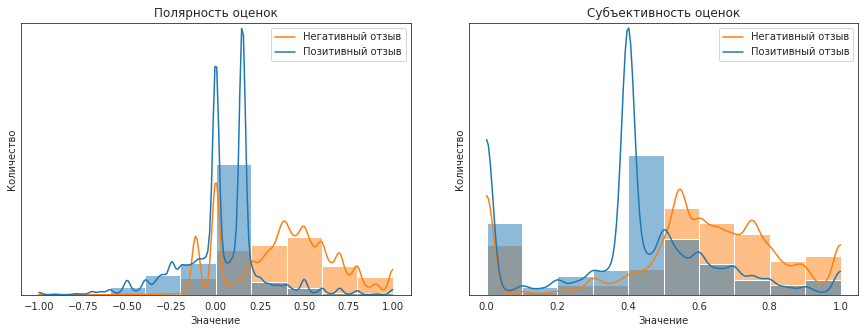

In [155]:
# Задаем словарь с параметрами
data_dict = {
    0: ['negative_polarity', 'positive_polarity', 645000, 'Полярность оценок'],
    1: ['negative_subjectivity', 'positive_subjectivity', 360000, 'Субъективность оценок'],
}

# строим графики
afig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=.15)

for i in data_dict:
    sns.histplot(data=data[[data_dict[i][0], data_dict[i][1]]], 
                 bins=10, 
                 ax=axes[i], 
                 kde=True)
    axes[i].set_title(data_dict[i][3], 
                      fontsize=12)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Количество')
    axes[i].legend(labels=['Негативный отзыв','Позитивный отзыв'])
    axes[i].set_yticks([])
    axes[i].axes.set_ylim(0, data_dict[i][2])

plt.show()

Распределение уже больше напоминает нормалное, тем не менее есть заметное и разнонаправленное для различных оценок смещение. 
Что интересно позитивные оценки больше смещены вправо к бОльшим значениям, а негативные в лево к меньшим. Отставим значения без изменения до следующего этапа.

Построим оценку при помощи библиотеки Afinn, котрая строит своего рода взвешенную по количеству слов оценку:

In [156]:
%%time
# получаем счет:
afinn = Afinn()
data['positive_afinn'] = data['positive_review'].apply(
    lambda x: afinn.score(x))
data['negative_afinn'] = data['negative_review'].apply(
    lambda x: afinn.score(x))

CPU times: user 10min 15s, sys: 83.8 ms, total: 10min 15s
Wall time: 10min 15s


Визуализируем результат

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


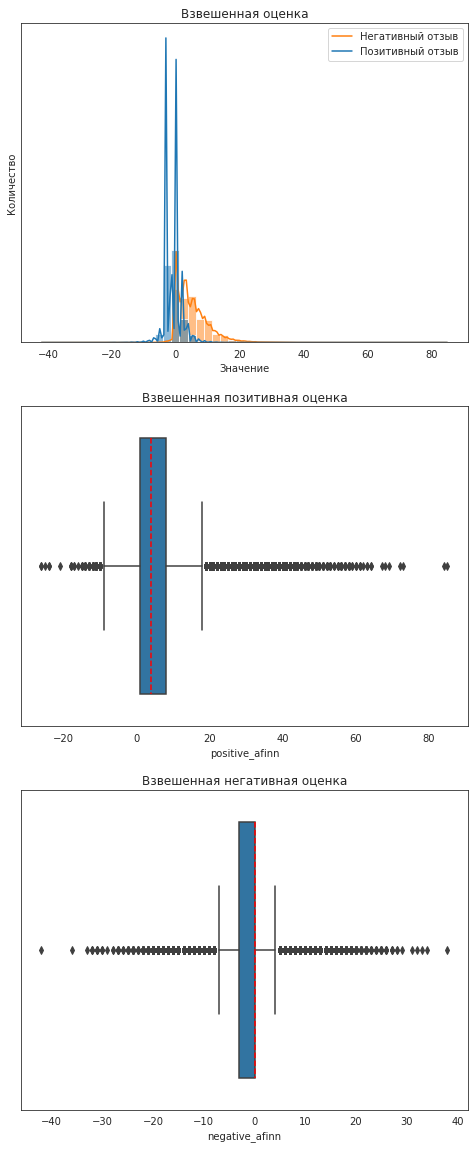

In [157]:
# строим графики
afig, axes = plt.subplots(3, 1, figsize=(8, 20))

sns.histplot(data=data[['negative_afinn','positive_afinn']], 
             bins=50, 
             ax=axes[0], 
             kde=True)
axes[0].set_title('Взвешенная оценка', 
                  fontsize=12)
axes[0].set_xlabel('Значение')
axes[0].set_ylabel('Количество')
axes[0].legend(labels=['Негативный отзыв','Позитивный отзыв'])
axes[0].set_yticks([])

sns.boxplot(data['positive_afinn'], 
            ax=axes[1], 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='')
axes[1].set_title('Взвешенная позитивная оценка')

sns.boxplot(data['negative_afinn'], 
            ax=axes[2], 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'})
axes[2].set(ylabel='')
axes[2].set_title('Взвешенная негативная оценка')

plt.show()

Распределение взвешенной оценки ближе всех из рассмотренных к нормальной, но имеют место быть длинные правые и левые хвосты и выбросы. 

Определим по методу Тьюки границы и преобразуем значения, выходящие за них для исключения выбросов.

In [158]:
# рассчитаем границы диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    """ Функция получения параметра полярности отзыва 
    
    Args:
        string (str): строка, передаваемая в обработку

    Returns:
        str: возвращает значение параметра полярности
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


positive_lower_bound, positive_upper_bound = get_outliers_bonds(
    data, 'positive_afinn')
negative_lower_bound, negative_upper_bound = get_outliers_bonds(
    data, 'negative_afinn')
print('Границы для позитивной оценки min {} max {}\n'.format(
    positive_lower_bound, positive_upper_bound))
print('Границы для негативной оценки min {} max {}'.format(
    negative_lower_bound, negative_upper_bound))

Границы для позитивной оценки min -9.5 max 18.5

Границы для негативной оценки min -7.5 max 4.5


In [159]:
# преобразуем признаки
data['positive_afinn'] = data['positive_afinn'].apply(
    lambda x: positive_lower_bound if x < positive_lower_bound else (positive_upper_bound if x > positive_upper_bound else x))
data['negative_afinn'] = data['negative_afinn'].apply(
    lambda x: negative_lower_bound if x < negative_lower_bound else (negative_upper_bound if x > negative_upper_bound else x))

Попробуем сформирвоать из отзывов мешок слов, создав для каждого уникального слова категориальную переменную. 

Учитывая большое количество слов ограничимся 32 наиболее часто встречающимися словами. 

In [160]:
# подготовим данные 
# переведём текст в нижний регистр и преобразуем строку в словарь
data['negative_review'] = data['negative_review'].apply(
            lambda x: x.lower().split())
data['positive_review'] = data['positive_review'].apply(
            lambda x: x.lower().split())

# удалим не текстовые символы
data['negative_review'] = data['negative_review'].apply(
            lambda x: [word for word in x if word.isalpha()])
data['positive_review'] = data['positive_review'].apply(
            lambda x: [word for word in x if word.isalpha()])


# преобразуем список в строку
data['negative_review'] = data['negative_review'].apply(lambda x: ' '.join(x))
data['positive_review'] = data['positive_review'].apply(lambda x: ' '.join(x))

In [161]:
def add_bag_of_words(df, column, prefix, max_words=32):
    """ Функция создающая мешок слов, формирующая категориальные признаки 
        для "max_words" наиболее часто встречающихся признаков
    
    Args:
        - исходный датафрейм
        - наименование колонки с текстом
        - префикс для формируемых колонок
        - переменная max_words - максимальнео количество наиболее часто
        встречающихся слов
    Returns:
        - df: возвращает измененный датафрейм с новыми признаками
        - список слов
    """
    vectorizer = CountVectorizer(max_features=max_words) 
    bag = vectorizer.fit_transform(df[column])
    
    count_array = bag.toarray()
    features = vectorizer.get_feature_names()
    
    prefixed_features = [prefix+element for element in features]
    
    bag_df = pd.DataFrame(data=count_array, columns=prefixed_features)
    
    return pd.concat([df, bag_df], ignore_index=False, axis=1), features

In [162]:
data, bow_neg = add_bag_of_words(data, 'negative_review', 'bow_n_')
data, bow_pos = add_bag_of_words(data, 'positive_review', 'bow_p_')

Эффективность преобразований оценим на этапе отбора признаков и вычислительных экспериментов.

### 2.2.3 review_total_negative_word_counts, review_total_positive_word_counts

In [163]:
data[['review_total_negative_word_counts', 'negative_review_word_counts']].head()

,review_total_negative_word_counts,negative_review_word_counts
0,52,50
1,10,9
2,3,1
3,0,1
4,0,1


In [164]:
list(data['negative_review'])[:5]

['would have appreciated a shop in the hotel that sold drinking water etc but not necessity would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby there is a minibar though if you want to pay those prices',
 'no tissue paper box was present at the room',
 'pillows',
 'no negative',
 'no negative']

In [165]:
data[['review_total_positive_word_counts', 'positive_review_word_counts']].head()

,review_total_positive_word_counts,positive_review_word_counts
0,62,60
1,0,1
2,5,4
3,27,26
4,7,5


In [166]:
list(data['positive_review'])[:5]

['hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city would definitely stay again',
 'no positive',
 'nice welcoming and service',
 'everything including the nice upgrade the hotel has been revamped and what a surprise love every second of it including in room dining which was excellent',
 'lovely hotel v welcoming staff']

При сравнении значений в колонках *'review_total_negative_word_counts', 'review_total_positive_word_counts'* с расчитанными самостоятельно значениями наблдается расхождение связанное как с тем, что значения типа *'no positive', 'no negative'* не учитываются, так и не понятные правила подсчёта, когда значения больше количества слов в строке. 

Визуализируем распределение признаков

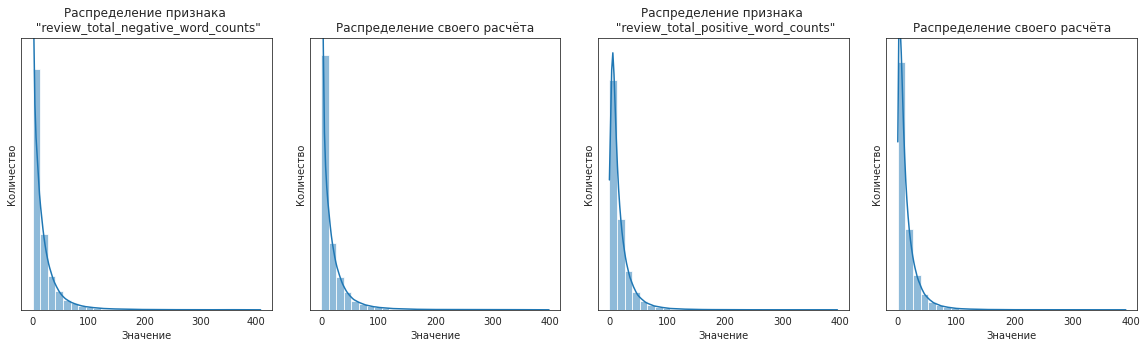

In [167]:
# Задаем словарь с параметрами
data_dict = {
    0: ['review_total_negative_word_counts', 'Распределение признака \n "review_total_negative_word_counts"'],
    1: ['negative_review_word_counts', 'Распределение своего расчёта'],
    2: ['review_total_positive_word_counts', 'Распределение признака \n "review_total_positive_word_counts"'],
    3: ['positive_review_word_counts', 'Распределение своего расчёта']
}

# строим графики
afig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.subplots_adjust(wspace=.15)

for i in data_dict:
    sns.histplot(data=data[data_dict[i][0]], 
                 bins=30, 
                 ax=axes[i], 
                 kde=True)
    axes[i].set_title(data_dict[i][1], 
                      fontsize=12)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Количество')
    axes[i].set_yticks([])
    axes[i].axes.set_ylim(0, 350000)

plt.show()

Распределения в целом повторяют друг друга, таким образом самостоятельно расчитаный признак считаю лишним, удалю.

Распределение сильно смещено влево, пролагорифмируем признаки 'review_total_negative_word_counts' и 'review_total_positive_word_counts' и визуализируем результат.

In [168]:
data['log_review_total_negative_word_counts'] = np.log(
    data['review_total_negative_word_counts']+0.1)
data['log_review_total_positive_word_counts'] = np.log(
    data['review_total_positive_word_counts']+0.1)

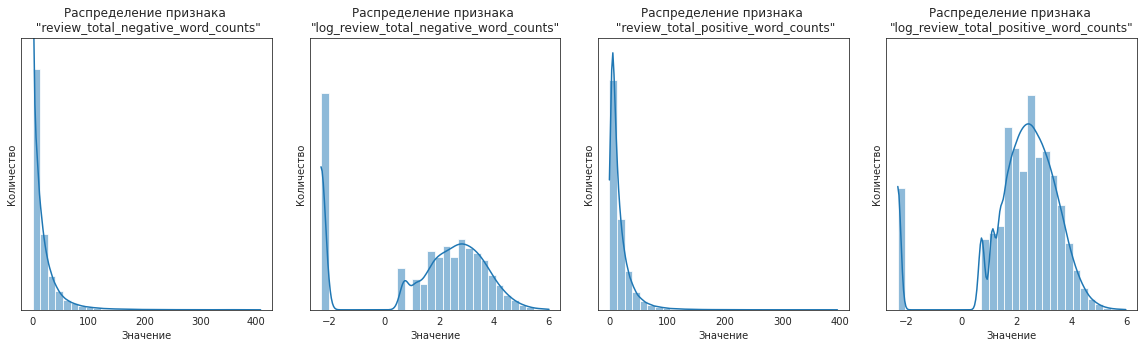

In [169]:
# Задаем словарь с параметрами
data_dict = {
    0: ['review_total_negative_word_counts', 350000, 'Распределение признака \n "review_total_negative_word_counts"'],
    1: ['log_review_total_negative_word_counts', 160000, 'Распределение признака \n"log_review_total_negative_word_counts"'],
    2: ['review_total_positive_word_counts', 350000, 'Распределение признака \n "review_total_positive_word_counts"'],
    3: ['log_review_total_positive_word_counts', 80000, 'Распределение признака \n"log_review_total_positive_word_counts"']
}
# строим графики
afig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.subplots_adjust(wspace=.15)

for i in data_dict:
    sns.histplot(data=data[data_dict[i][0]], 
                 bins=30, 
                 ax=axes[i], 
                 kde=True)
    axes[i].set_title(data_dict[i][2], 
                      fontsize=12)
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Количество')
    axes[i].set_yticks([])
    axes[i].axes.set_ylim(0, data_dict[i][1])

plt.show()

 В результате распределение несколько приблизилось к нормальному,сохраним исходный и логарифмированный вараинт до этапа отбора признаков.

### 2.3.1 reviewer_nationality

In [170]:
print('Количество уникальных стран рецензентов {}\nРаспределение количества отзывов по странам'.format(
    data['reviewer_nationality'].nunique()))
data['reviewer_nationality'].value_counts(normalize = True)[:15]

Количество уникальных стран рецензентов 227
Распределение количества отзывов по странам


 United Kingdom               0.475650
 United States of America     0.068661
 Australia                    0.042029
 Ireland                      0.028753
 United Arab Emirates         0.019847
 Saudi Arabia                 0.017354
 Netherlands                  0.016999
 Switzerland                  0.016825
 Germany                      0.015397
 Canada                       0.015302
 France                       0.014118
 Israel                       0.012813
 Italy                        0.011860
 Belgium                      0.011693
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

Обращает на себя внимание большое количество рецензентов из Великобритании, что коррелируется с наибольшим количеством отелей в датафрейме, так же из Великобритании. Посмотрим какое количество рецензентов проживаю в той же стране, где находится рецензируемый отель. 
> для этого создадим признак *reviewer_in_hotel_country*

In [171]:
# удаляем лишние пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x: x.lstrip().rstrip())

# получаем новый признак
data['reviewer_in_hotels_country'] = data.apply(
    lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

data['reviewer_in_hotels_country'].value_counts(normalize = True)

0    0.653913
1    0.346087
Name: reviewer_in_hotels_country, dtype: float64

34,6% отзывов принадлежит жителям страны, в которой расположен отель. Признак кажется интересным, посмотрим как распределились средние оценки в этих группах и визуализируем результат.

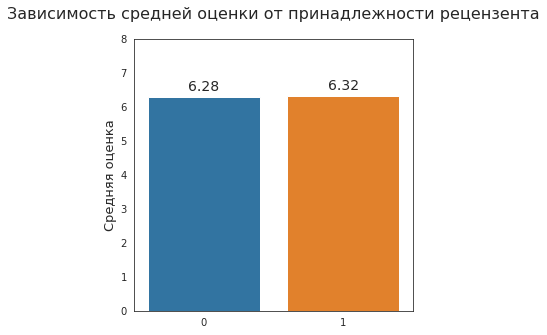

In [172]:
# построим график зависимости средней оценки
build_barplot(data, 'reviewer_in_hotels_country', 'reviewer_score', 'mean', 
              ['Зависимость средней оценки от принадлежности рецензента', '', 'Средняя оценка'],0)

Различия в средних оценках не велики, сам по себе признак новой информации не несёт.

Основная масса отзывов принадлежит рецензентам из 15 стран, преобразуем признак, заменив остальных рецензентов на 'other'.

In [173]:
# зададим функцию для сокращения размерности
def reduce_columns(df, column, number, change_word):
    """ Функция уменьшающая количество категорий и возвращающая
    измененный датафрейм
    
    Args:
        - df: исходный датафрейм
        - column: наименование колонки
        - number: количество значений с наибольшим количествтом записей,
        которое будет оставлено
        - change_word: значение на котрое будут заменены редуцируемые значения
    Returns:
        - df: возвращает измененный датафрейм
    """
    names_list = list(df[column].value_counts().nlargest(number).index)
    df[column] = df[column].apply(
        lambda x: x if x in names_list else change_word) 
    return df

data = reduce_columns(data, 'reviewer_nationality', 15, 'Other')

Посмотрим какие средние оценки рецензентов из разных стран.

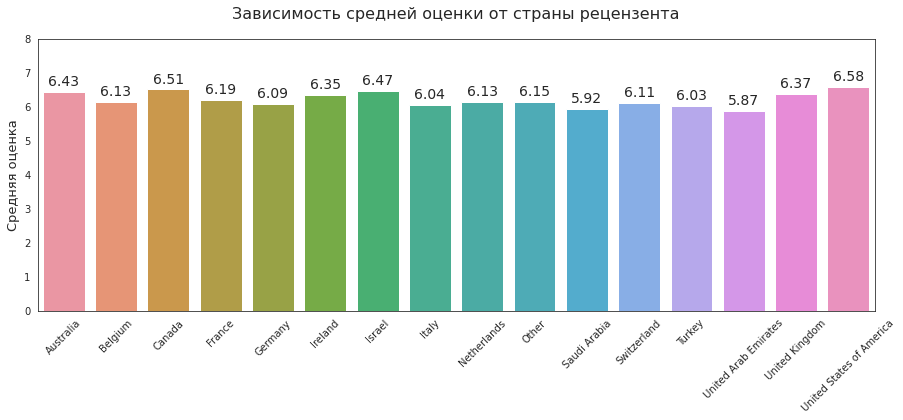

In [174]:
# построим график зависимости средней оценки от страны рецензента
build_barplot(data, 'reviewer_nationality', 'reviewer_score', 'mean', 
              ['Зависимость средней оценки от страны рецензента', '', 'Средняя оценка'],45,15)

Самые высокие оценки ставили путешественники из США, Канады и Израиля, а самые низкие путешественники из арабских стран.

### 2.3.2 total_number_of_reviews_reviewer_has_given

In [175]:
data['total_number_of_reviews_reviewer_has_given'].describe()

count    515431.000000
mean          7.165215
std          11.038742
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

In [176]:
data['total_number_of_reviews_reviewer_has_given'].value_counts()[:10]

1     154561
2      67036
3      46818
4      35008
5      27614
6      22604
7      18606
8      16139
9      13532
10     11708
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


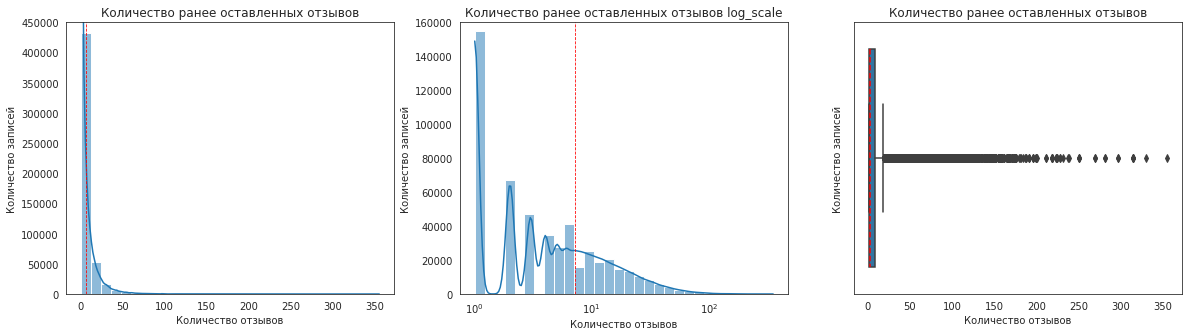

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data['total_number_of_reviews_reviewer_has_given'], 
             log_scale=False, 
             bins=30, 
             kde=True, 
             ax=axes[0])
axes[0].set(xlabel='Количество отзывов', 
            ylabel='Количество записей')
axes[0].set_title('Количество ранее оставленных отзывов')
axes[0].axvline(data['total_number_of_reviews_reviewer_has_given'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

sns.histplot(data['total_number_of_reviews_reviewer_has_given'], 
             log_scale=True, 
             bins=30, 
             kde=True, 
             ax=axes[1])
axes[1].set(xlabel='Количество отзывов', 
            ylabel='Количество записей')
axes[1].set_title('Количество ранее оставленных отзывов log_scale')
axes[1].axvline(data['total_number_of_reviews_reviewer_has_given'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8)

sns.boxplot(data['total_number_of_reviews_reviewer_has_given'], 
            ax=axes[2], 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'})
axes[2].set(xlabel='Количество отзывов', 
            ylabel='Количество записей')
axes[2].set_title('Количество ранее оставленных отзывов')

axes[0].axes.set_ylim(0, 450000)
axes[1].axes.set_ylim(0, 160000)
plt.show()

Распределение признака сильно смещено влево, напоминает логнормальное. Оставим как есть, ценность определим на этапе отбора признаков.

### 2.3.3 tags

Взглянем на теги

In [178]:
tags_list = list(data['tags'])
tags_list[:15]

["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",
 "[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",
 "[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",
 "[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Business trip ', ' Solo traveler ', ' Standard Double or Twin Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Couple ', ' Queen Room ', ' Stayed 1 night ']",
 "[' Business trip ', ' Solo traveler ', ' Executive Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
 "[' Group ', ' Double or Twin Room ', ' Stayed 1 night ']",
 "[' Couple ', ' Standard Triple Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night 

Очистим строки от лишних символов

In [179]:
data['tags'] = data['tags'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("' ", '').replace(" '", ''))
list(data['tags'])[:5]

['Leisure trip, Couple, Double Room, Stayed 2 nights',
 'Leisure trip, Group, Triple Room, Stayed 1 night',
 'Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device',
 'Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night',
 'Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device']

Вычислим максимальное количество тегов в строке

In [180]:
data['len_tags'] = data['tags'].apply(lambda x: len(x.split(',')))

print('Максимальное количество тегов в 1 строке данных: {}\n'.format(
    data["len_tags"].max()))
print(data[data['len_tags'] == data['len_tags'].max()]['tags'].iloc[0])

Максимальное количество тегов в 1 строке данных: 6

With a pet, Leisure trip, Family with young children, Double or Twin Room 1 2 Adults, Stayed 7 nights, Submitted from a mobile device


Можно выделить 7 типов тегов на основании которых можно создать следующие признаки:

- бинарный признак - путешествие с домашними животными *'tag_trip_with_pet'* 1 с животным, 0 - без
- бинарный признак - путешествие по работе / отдых *'tag_business_leisure_trip'* 1 - отдых, 0 - по работе
- категориальный признак - путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа) *'tag_reviewer_type'*
- категориальный признак - категория номера *'tag_room_type'*
- порядковый признак - длительность поездки *'tag_count_nights'* от 1 до максимального количества дней поездки 
- бинарный признак - заказ осуществляется с мобильного устройства *'tag_from_mobile'* 1 - с мобильного устройства, 0 - не с мобильного устройства
- бинарный признак - наличия видовых преимуществ *'tag_view_room'* 1 - есть, 0 - нет
> создадим новые признаки

In [181]:
def get_tags(string):
    """ Функция кодирования отдельных тегов в новый признак

    Args:
        string (str): строкое значение признака 'tags', 
        передаваемое в обработку

    Returns:
        int: возвращает коды будущих признаков
    """
    # формируем список
    tags_list = string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # зададим словарь типов путешественников
    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    # задаем новые признаки
    tag_from_mobile = 0
    tag_trip_with_pet = 0
    tag_business_leisure_trip = 1
    tag_reviewer_type = 1
    tag_count_nights = 1
    tag_view_room = 0
    tag_room_type = 'Other'

    # при заполнении признаков ищем признак по маске, если обнаружен
    # - присваиваем значение признаку и удаляем тег из списка
    # таким образом в конце может остаться тип номера, не имеющий шаблона
    
    for tag in list(tags_list):
        if tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(tag)

        if tag == 'With a pet':
            tag_trip_with_pet = 1
            tags_list.remove(tag)

        if tag == 'Business trip':
            tag_business_leisure_trip = 0
            tags_list.remove(tag)

        if tag == 'Leisure trip':
            tags_list.remove(tag)

        if tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[tag]
            tags_list.remove(tag)
            if tags_list==0:
                print(tags_list)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', tag):
            tag_count_nights = [int(n) for n in re.findall(r'-?\d+\.?\d*', 
                                                           tag)][0]
            tags_list.remove(tag)

        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_trip_with_pet, tag_business_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

# создаем новые признаки
data[['tag_from_mobile', 'tag_trip_with_pet', 'tag_business_leisure_trip',
      'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 
      'tag_room_type']
     ] = pd.DataFrame(data['tags'].apply(get_tags).to_list(), index=data.index)

In [182]:
# посмотрим сколько значений получилось для признаков
# 'tag_reviewer_type', 'tag_count_nights', 'tag_room_type'
data[['tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()

tag_reviewer_type       6
tag_count_nights       31
tag_room_type        2394
dtype: int64

В признаке *'tag_room_type'* количество значений слишком велико, попробуем выделить основные группы типов комнат

In [183]:
def get_room_type(tag):
    """Классификация типа номера."""
    room_types = ['Without Window', 'Classi', 'Single', 'Triple',
                  'Executive','Standard', 'Superior', 'Comfort',
                  'Club', 'Suite', 'Guest', 'Deluxe', 'King', 'Queen'
                 ]
    for rt in room_types:   
        if rt in tag:            
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'

# группируем данные с типом номера:
data['room_type'] = data['tag_room_type'].apply(get_room_type)

Визуализируем результат

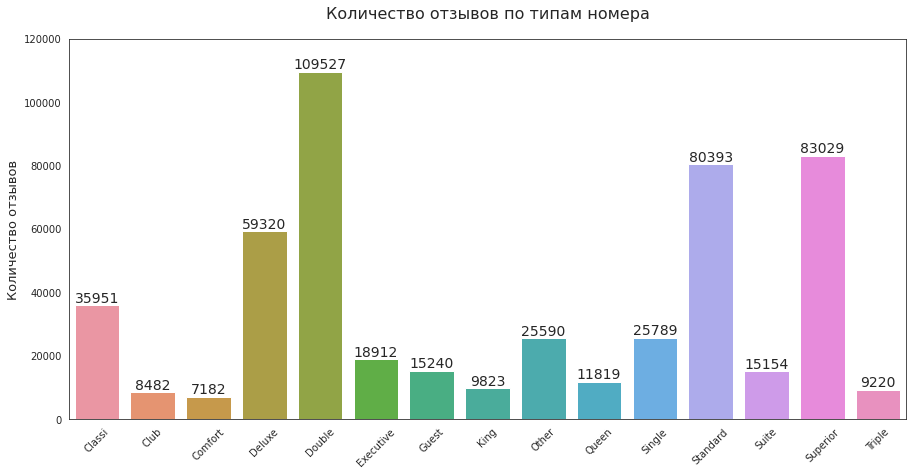

In [184]:
# посчитаем количество номеров по типам
cross_table = pd.pivot_table(data, 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['count'])
    # построим график
fig, axes = plt.subplots(figsize=(15, 7))

bar_types = sns.barplot(
        x=cross_table.index, 
        y=cross_table['count', 'reviewer_score'])
axes.set_title('Количество отзывов по типам номера', 
               pad = 20, 
               size=16)
axes.set_xlabel('', fontsize=13)
axes.set_ylabel('Количество отзывов', 
                fontsize=13)
plt.xticks(rotation = 45)

for p in bar_types.patches:
    bar_types.annotate('{:.0f}'.format(p.get_height()), 
                       (p.get_x()+0.4, p.get_height()+0.1),
                       ha='center', 
                       va='bottom', 
                       fontsize=14)

plt.ylim(0, 120000)
plt.show();

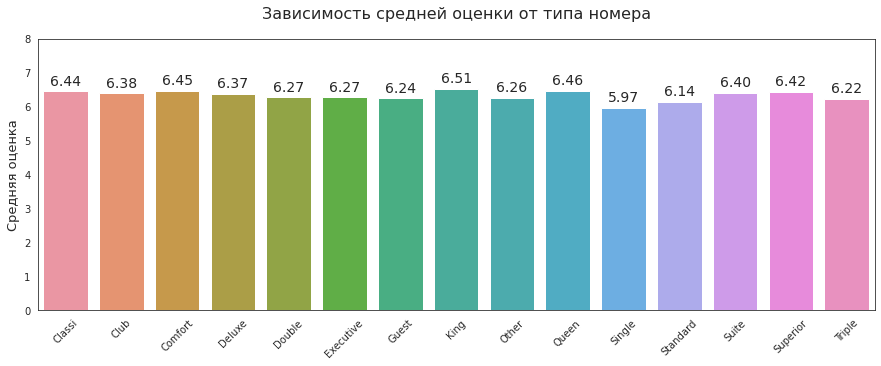

In [185]:
# построим график зависимости средней оценки от страны рецензента
build_barplot(data, 'room_type', 'reviewer_score', 'mean', 
              ['Зависимость средней оценки от типа номера', '', 'Средняя оценка'],45,15)

Можно отметить , что средние оценки разнятся, в зависимости от типа комнаты, не смотря на маленькое количество значений признак *'Without Window'* интересен и некой особеностью таких номеров и низкой, что ожидаемо, оценкой. Для усиления эффекта создадим синтетический признак:
- *'count_score_room_type'* - значение средней оценки для отзыва, умноженное на количество отзывов с данным типом номера, разделенная на 10000

In [186]:
%%time
count_score_count = data.groupby('room_type')['reviewer_score'].count()/10000
count_score_table = data.groupby('room_type')['reviewer_score'].mean()
data['count_score_room_type'] = data.apply(
    lambda x: count_score_table[x.room_type]*count_score_count[x.room_type], 
    axis=1)
data['count_score_room_type'].head(10)

CPU times: user 30.9 s, sys: 854 ms, total: 31.8 s
Wall time: 31.8 s


0    68.68077
1     5.73802
2    68.68077
3     9.69315
4    23.16738
5    49.35116
6     7.63684
7    11.84895
8    68.68077
9     5.73802
Name: count_score_room_type, dtype: float64

Удалим колонку *'tag_room_type'*

In [187]:
data = data.drop('tag_room_type', axis = 1)

Посмотрим как распределилось количество отзывов в звыисимости от длительности пребывания в отеле

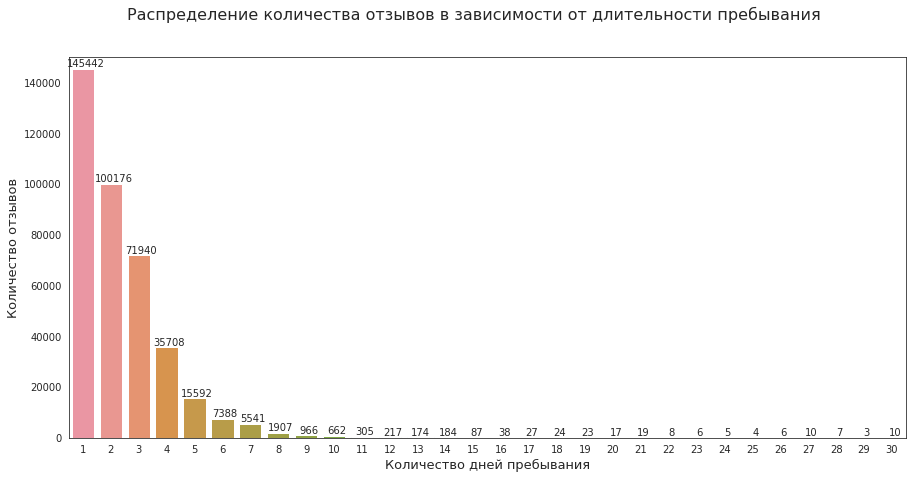

In [188]:
pivot_nights = pd.pivot_table(
    data[data['sample'] == 1], 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])

fig, axes = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', 
    size=16)
bar_types = sns.barplot(x=pivot_nights.index, 
                        y=pivot_nights[('count', 'reviewer_score')], 
                        ax=axes);
axes.set_xlabel('Количество дней пребывания', 
                fontsize=13)
axes.set_ylabel('Количество отзывов', 
                fontsize=13)

for p in bar_types.patches:
    bar_types.annotate('{:.0f}'.format(p.get_height()),
                       (p.get_x()+0.5, p.get_height()+0.1),
                       ha='center', 
                       va='bottom', 
                       fontsize=10)

plt.ylim(0, 150000)
plt.show();

Смещение распределения ожидаемо, оценим занчимость признаков на следующем этапе.

Создадим категориальные признаки на основании признаков *'room_type', 'tag_reviewer_type', 'country'*

In [189]:
data = pd.get_dummies(data, columns=['room_type', 'tag_reviewer_type', 'country'],
                      dtype='int16')

# 3. Очистка и отбор признаков

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Columns: 161 entries, hotel_address to country_United Kingdom
dtypes: datetime64[ns](1), float64(40), int16(28), int64(83), object(9)
memory usage: 554.5+ MB


Удалим признаки с типом 'object' на них модель не сможет обучаться

In [191]:
print('Общее количество признаков: {}'.format(len(data.columns)))
# подготовим списко колонок с данными типа 'object'
object_columns = [col for col in data.columns if (
    (data[col].dtypes == 'object') | (data[col].dtypes == 'datetime64[ns]'))]

# смотрим, что попадает под удаление
print('Обнаружено {} столбцов с нечисловыми данными:'.format(len(object_columns)))
object_columns

Общее количество признаков: 161
Обнаружено 10 столбцов с нечисловыми данными:


['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'city_x',
 'zip',
 'city_y']

In [192]:
# удаляем отобранные колонки
data.drop(object_columns, axis = 1, inplace=True)

Остались колонки с числовыми значениями, подразделяющимися на категориальные и числовые непрерывные признаки.

In [193]:
# распределим признаки по группам
cat_cols = []
int_cols = []
num_cols = []
for col in data.columns:
    if (data[col].dtypes == 'int64'):
        int_cols.append(col)
        if data[col].nunique()<50:
            cat_cols.append(col)
        
num_cols = list(set(data.columns) - set(cat_cols) - {'reviewer_score'})
cat_cols = list(set(cat_cols) - {'sample'})
print('Всего колонок {}\nКатегориальные признаки {}\n\
Числовые признаки {}\n\
Колонки для снижения размера датасета {}'.format(len(data.columns),
                                                 len(cat_cols),
                                                 len(num_cols),
                                                 len(int_cols)))

Всего колонок 151
Категориальные признаки 75
Числовые признаки 74
Колонки для снижения размера датасета 83


Поскольку диапазон числовых значений категориальных признаков не велик с целью сокращения объёма используемой памяти преобразуем тип переменной в 'int16'.

In [194]:
convert_dict = {key:np.int16 for key in int_cols}
data = data.astype(convert_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Columns: 151 entries, additional_number_of_scoring to country_United Kingdom
dtypes: float64(40), int16(111)
memory usage: 270.4 MB


Объём используемой памяти соратился практически в два раза.

Оценим корреляцию признаков, визуализируем корреляцию, корреляционную матрицу построим по методу Спирмена.

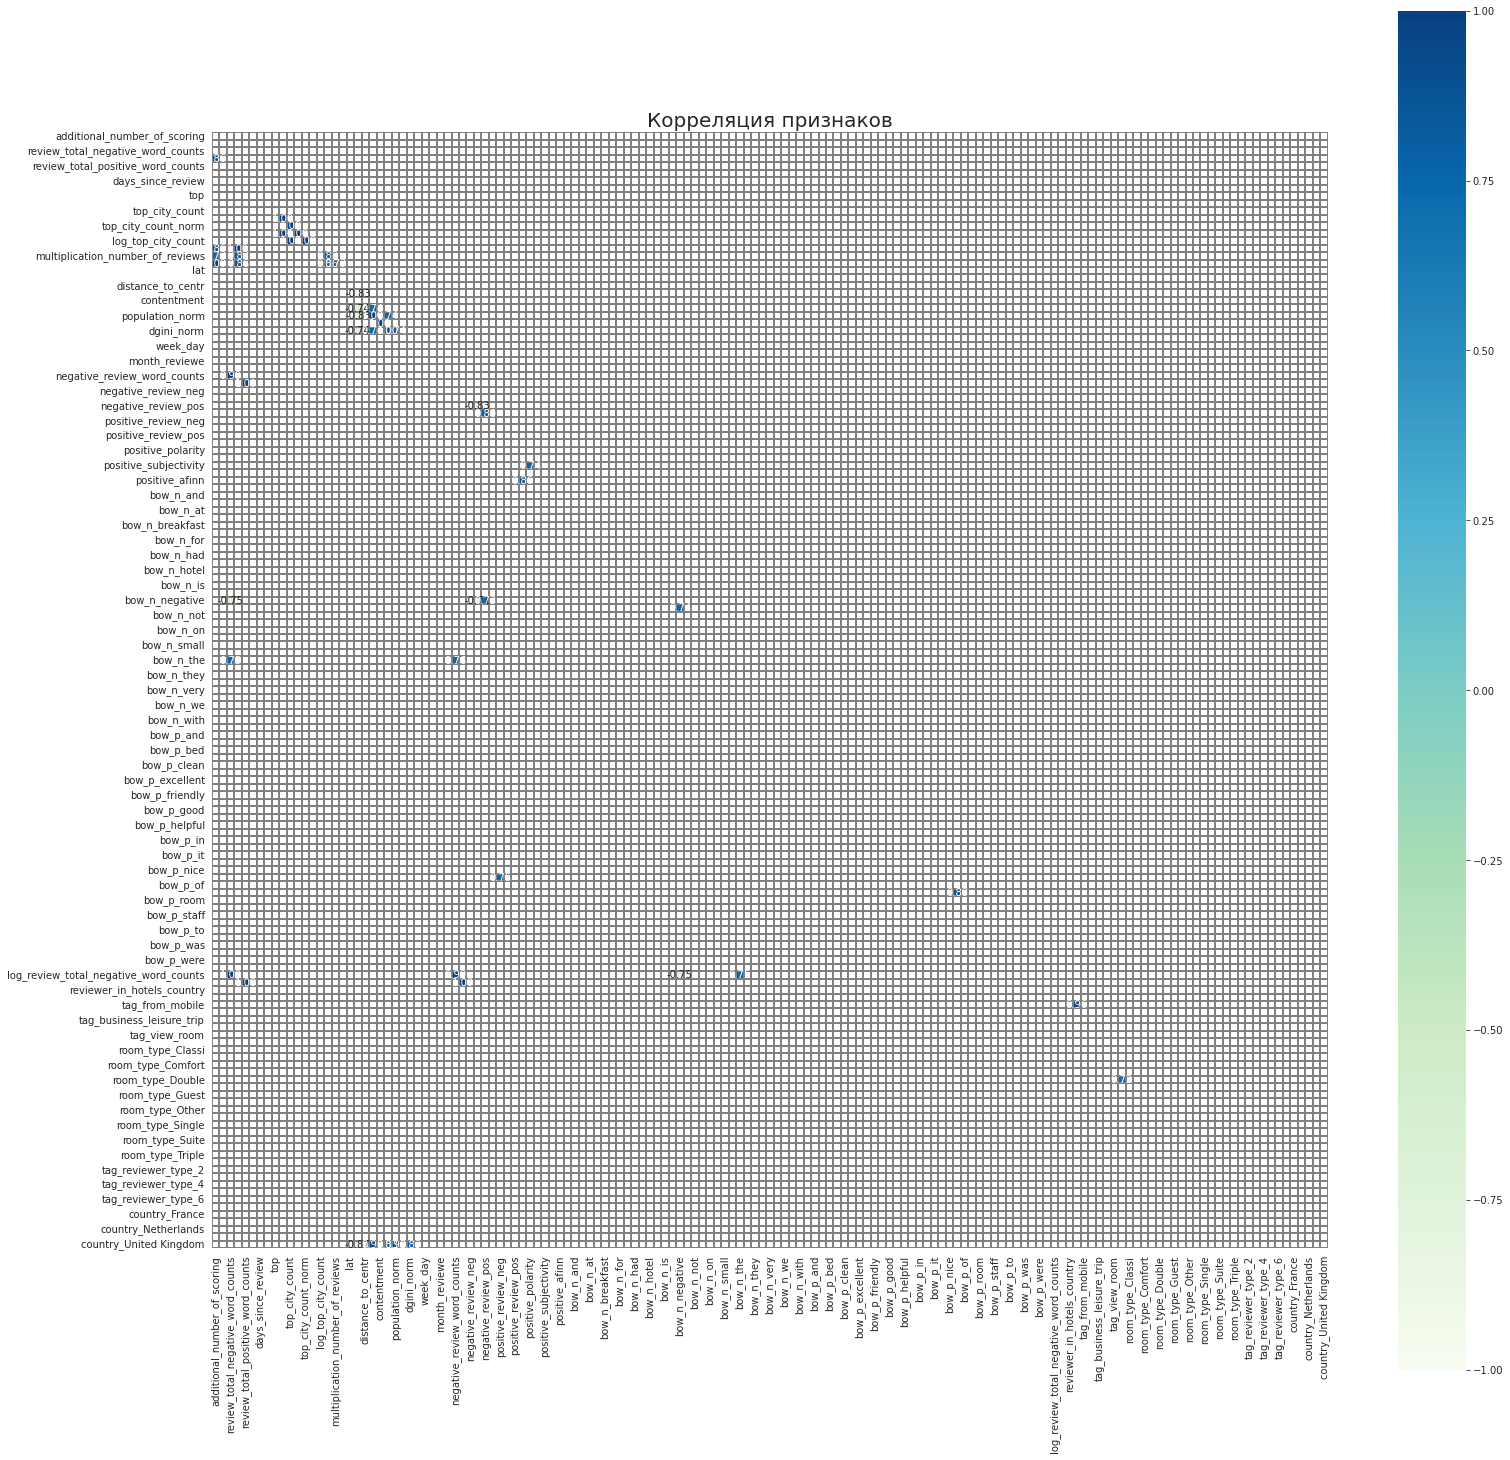

In [195]:
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(25, 25))

# для повышения информативности отобраения
# на графике - тепловой матрицы покажем значения 
# с коэффициентами корреляции не менее 0.7
heatmap = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='GnBu',
    mask=mask, 
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
heatmap.set_title('Корреляция признаков', fontsize=20);

В следствии большого количества признаков матрица не информативна, значения не читаемы.

Раздельно оценивать корреляцию числовых и категориальных признаков считаю не верным, поскольку при этом не будет возможности оценить скоррелированность числовых признаков с категориальными и наоборот.

Попробуем сгруппировать скоррелированные прризнаки со значенимми корреляции более 0.7 в виде таблицы

In [196]:
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='pearson')
print('Корреляция между признаками не менее 0.7:')
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr coeff' }).\
     sort_values(by = 'Corr coeff', ascending = False)
corr_final = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.7))].\
  iloc[0::2,:].reset_index(drop = True)
corr_final

Корреляция между признаками не менее 0.7:


,feature 1,feature 2,Corr coeff
0,top_city_count_norm,top_city_count,1.000000
1,population,population_norm,1.000000
2,top_reviewer,top_reviewer_norm,1.000000
3,dgini_norm,dgini,1.000000
4,contentment_norm,contentment,1.000000
5,positive_review_word_counts,review_total_positive_word_counts,0.999180
6,negative_review_word_counts,review_total_negative_word_counts,0.998996
7,population_norm,country_United Kingdom,0.996205
8,population,country_United Kingdom,0.996205
9,positive_review_neg,bow_p_positive,0.942424


Количество признаков с высокими коэффициентами корреляции достаточно велико

Однако удалять их пока не будем, сначал оценим их значимость, а затем проведем эксперемены с удалением признаков и оценим эффективность этих действий.

    для оценки значимости признаков будем использовать тесты:

    хи-квадрат - для категориальных,
    тест ANOVA - для числовых (непрерывных) признаков.



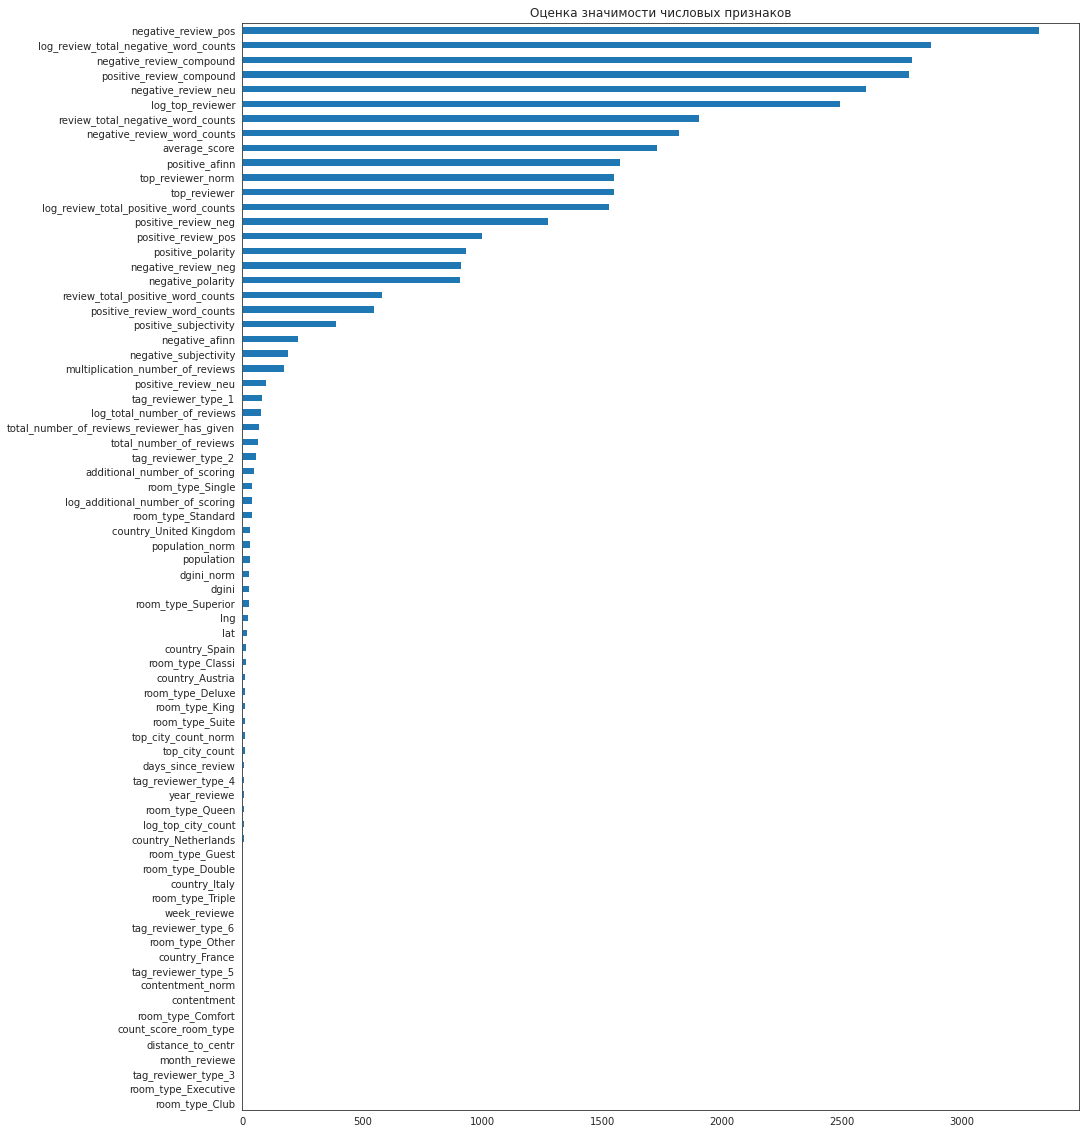

In [197]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
# для числовых переменных
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig, axes = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh',
             title = 'Оценка значимости числовых признаков')

plt.show();

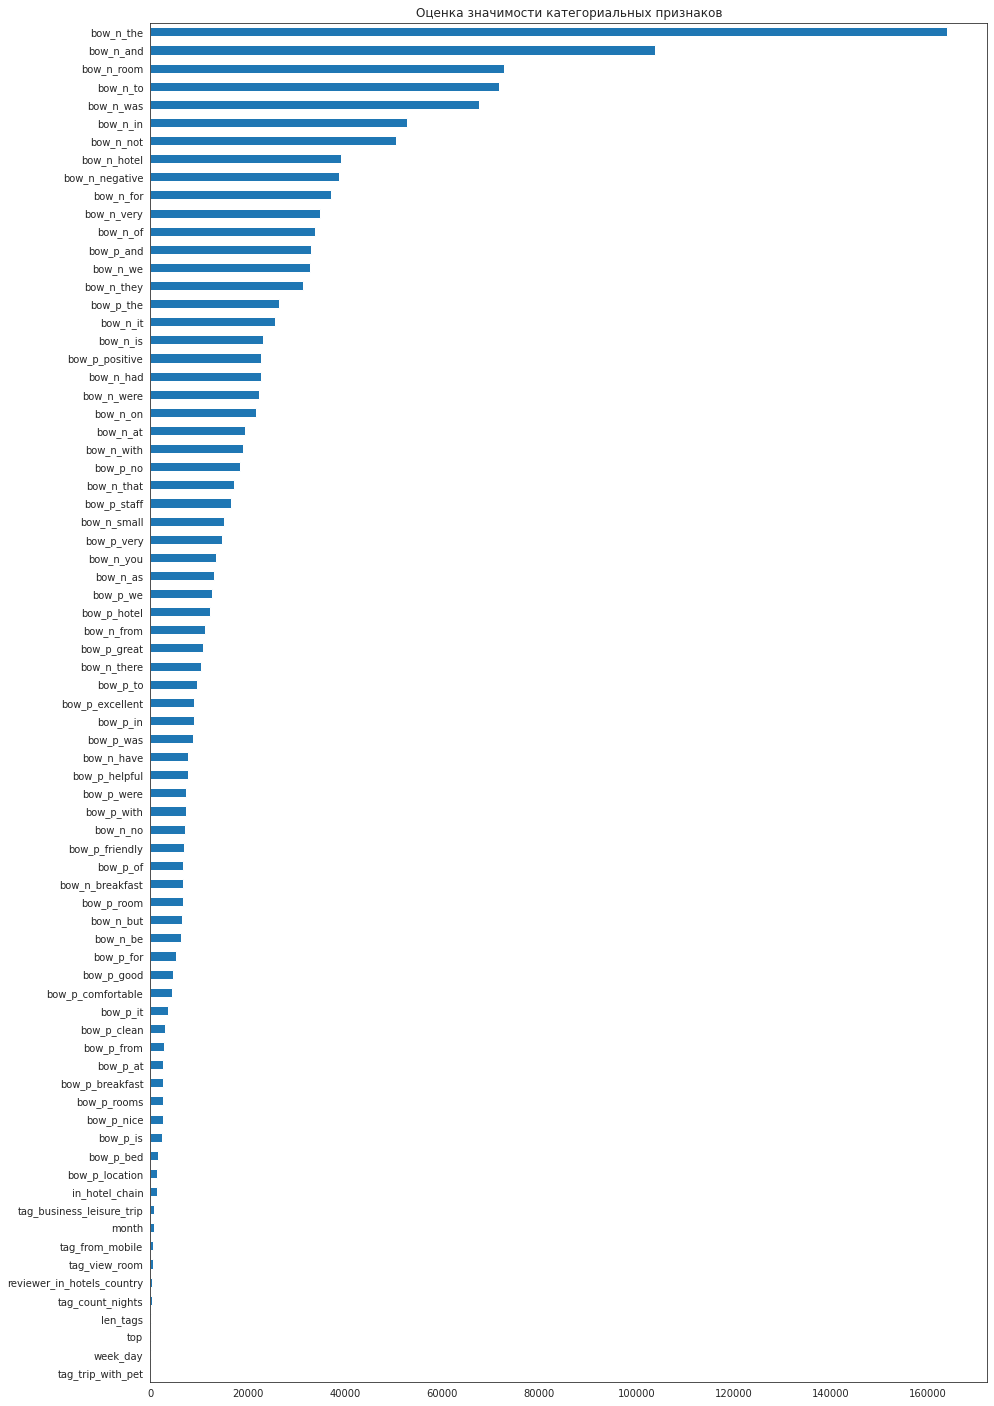

In [198]:
# для категориальных переменных 
y = y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index = cat_cols)
imp_cat.sort_values(inplace = True)

fig, axes = plt.subplots(figsize=(15, 25))
imp_cat.plot(kind = 'barh', 
             title='Оценка значимости категориальных признаков');

Обращает на себя внимание высокая значимость признаков, связанных с оценками туристов, как среди числовых, так и среди категориальных признаков.

Часть признаков, на первый взгляд, не имеют значимости, посмотрим так ли это.

In [199]:
print('Минимальное значение значимости числового признака {}\n\
Минимальное значение значимости категориального признака {}'.format(imp_num.min(),imp_cat.min()))

Минимальное значение значимости числового признака 0.7507313334546595
Минимальное значение значимости категориального признака 34.35280689559675


Получается, что признаков с нулевой значимостью нет, хотя есть некоторое количество с низкой.

Проведем серию экспериментов с целью оценить, что больше влияет на точность работы модели.

Коэффициент значимости или мультиколинеарность высокоскоррелированных признаков.

# 3. Обучение модели и получение предсказания 

Проведена серия экспериментов для подтверждения ранее выдвинутых гипотез и подбора параметров датасета для оптимизации значения метрики.

1. Получено базовое предсказание, для чего модель обучена на неизменном датафрейме. 
> В результате получено выраженное переобучение, со значением метрики MAPE = 0.013.
2. Удалены из датафрейма признаки по которым коэффициент корреляции превысил 0.7. 
> Получено значение мерики 12.32 на лидерборде
3. Проведены экспереименты по избирательному удалению признаков в зависимости от их коэффициента значимости.
> Положительного влияния на метрику не получено
4. Проведено сравнение удаления неизменных и логарифмированных признаков.
> Так же существенного роста не получено
5. Проведен эксперимент для определения границы переобучения. Для чего признаки удалялись поочередно по списку высоко коррелированных признаков до прекращения резко выраженного переобучения.
> переобучаться модель начинает при количестве признаков более 121
> порядок удаления не повлиял на результат
6. Проведено сравнение результатов обучения при повышении границы корреляции признаков, по значению которой признаки отбирались на удаление в диапазоне от 0.8 до 0.85. Получен результат:
- 80 MAPE: 11.85
- 0.81 MAPE: 11.81
- 0.82 - 0.84 MAPE: 11.83045497
- 0.85 - переобучение
> Таким образом наилучшийрезультат получен на границе коэффициента корреляции признаков 0.81. Значение метрики MAPE: 11.85, на лидерборде 11.86 .

Можно сделать общий вывод:

Признаки с большой степенью корреляции оказывают отрицательное значение и приводят к переобучению модели. Наибольшее значение для обучения модели имели признаки, связанные с отзывами путешественников, в меньшей степени признаки, основанные на разборе тегов, остальные признаки имеют меньшую значимость. Логарифмирование признаков не оказало значительного влияния на качество работы модели. За счёт удаления сильно коррелированных признаков удалось получить обучение модели с приемлемыми значениями метрики. 

Проведем обучение модели с подобранными параметрами

In [203]:
# получим список признаков с высокой корреляцией для удаления
# получим датафрейм с коррелированными признаками
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='pearson')
print('Корреляция между признаками не менее 0.81:')
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr coeff' }).\
     sort_values(by = 'Corr coeff', ascending = False)
corr_final = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.81))].\
  iloc[0::2,:].reset_index(drop = True)

# список на удаление
dell_list = list(set(corr_final['feature 1']).union(set(corr_final['feature 2'])))

# удаление
dell_data = data.drop(dell_list, axis=1)

Корреляция между признаками не менее 0.81:


In [204]:
# Теперь выделим тестовую часть
train_data = dell_data.query('sample == 1').drop(['sample'], axis=1)
test_data = dell_data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [205]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [206]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 113), (386496, 113), (386496, 112), (309196, 112), (77300, 112))

In [207]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, 
                              verbose=1, 
                              n_jobs=-1, 
                              random_state=RANDOM_SEED)

In [208]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [209]:
# зададим функцию для расчёта метрики
def mean_absolute_percentage_error(y_test, y_pred):
    """ Функция для расчёта метрики MAPE 
    
    Args:
        y_test: значения целевой переменной валидационной
                выборки
        y_pred: предсказанное значение целевой переменной
                на валидационной выборке
    Returns:
        float: значение метрики MAPE
    """
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# расчёт метрики
print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 8))

MAPE: 11.81483911


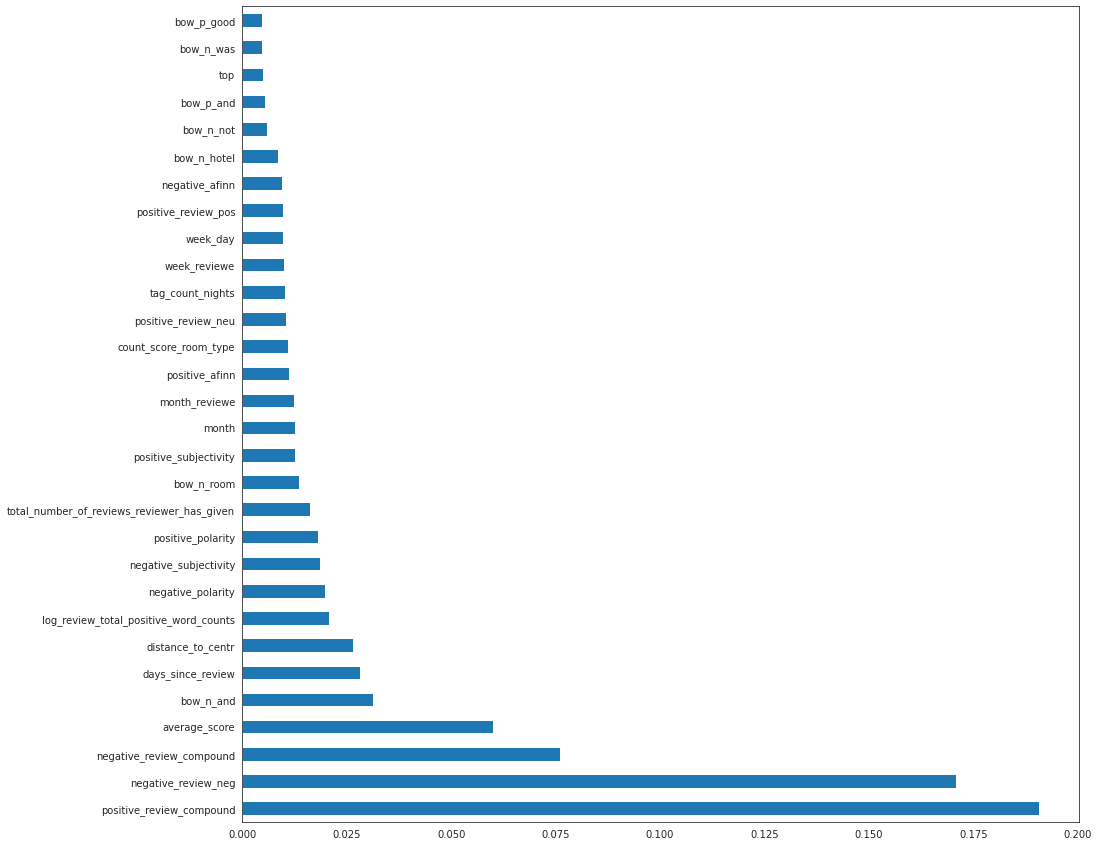

In [218]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh');

In [211]:
test_data.sample(10)

,average_score,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,in_hotel_chain,top,distance_to_centr,month,week_day,year_reviewe,...,room_type_Superior,room_type_Triple,tag_reviewer_type_1,tag_reviewer_type_2,tag_reviewer_type_3,tag_reviewer_type_4,tag_reviewer_type_5,tag_reviewer_type_6,country_Italy,country_Netherlands
33675,8.9,3,455,0.0,0,2,2.248777,5,4,16.687637,...,0,0,1,0,0,0,0,0,0,0
2350,9.2,14,187,0.0,0,3,3.153236,1,6,9.869666,...,0,0,0,1,0,0,0,0,0,0
52926,8.5,1,144,0.0,1,1,4.116124,3,7,9.869666,...,1,0,0,1,0,0,0,0,0,0
60532,8.8,2,640,0.0,0,1,0.663612,11,1,5.897920,...,1,0,1,0,0,0,0,0,1,0
102179,9.3,4,161,0.0,0,1,1.022810,2,4,9.869666,...,0,0,0,1,0,0,0,0,0,0
46496,8.0,1,487,0.0,1,1,4.092231,4,7,16.687637,...,0,0,0,1,0,0,0,0,0,0
102604,8.7,6,338,0.0,0,3,1.375041,8,2,16.687637,...,0,0,0,1,0,0,0,0,0,0
85624,8.4,1,633,0.0,0,3,0.687515,11,1,5.897920,...,0,0,0,1,0,0,0,0,0,0
21203,8.6,4,561,0.0,1,1,0.356775,1,3,16.687637,...,0,0,0,0,0,0,0,1,1,0
71742,8.7,6,212,0.0,0,1,1.697296,1,2,9.869666,...,1,0,0,1,0,0,0,0,0,0


In [212]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [213]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [214]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [215]:
predict_submission

array([9.057, 7.809, 8.508, ..., 8.01 , 9.476, 6.216])

In [216]:
list(sample_submission)

['reviewer_score', 'id']

In [217]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,9.057,488440
1,7.809,274649
2,8.508,374688
3,9.831,404352
4,9.697,451596
5,8.406,302161
6,7.573,317079
7,8.094,13963
8,8.168,159785
9,7.582,195089
